<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [20]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [21]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [22]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [23]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="8",
                             total_timesteps=3000000)

load
Logging to ppo/8_3
----------------------------------
| time/              |           |
|    fps             | 117       |
|    iterations      | 1         |
|    time_elapsed    | 17        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2954527 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2            |
|    time_elapsed         | 36           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0139981955 |
|    clip_fraction        | 0.178        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.0106      |
|    learning_rate        | 0.00025      |
|    loss                 | 3.97         |
|    n_updates            | 10           |
|    policy_grad

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 12          |
|    time_elapsed         | 219         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.017950803 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.5       |
|    explained_variance   | 0.00618     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.6         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0187     |
|    reward               | -0.14442861 |
|    std                  | 1.01        |
|    value_loss           | 16.2        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5673966.50
total_reward: 4673966.50
total_cost: 329987.39
total_trades: 78769
Sharpe: 0.93

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 22          |
|    time_elapsed         | 400         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.029196676 |
|    clip_fraction        | 0.305       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.9       |
|    explained_variance   | -0.00835    |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0168     |
|    reward               | 2.1931765   |
|    std                  | 1.03        |
|    value_loss           | 36.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 32          |
|    time_elapsed         | 582         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.020606091 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.5       |
|    explained_variance   | -0.0353     |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0148     |
|    reward               | -0.71887743 |
|    std                  | 1.05        |
|    value_loss           | 21.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 42          |
|    time_elapsed         | 764         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.037621442 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.0146      |
|    learning_rate        | 0.00025     |
|    loss                 | 52.8        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00052    |
|    reward               | 0.21551542  |
|    std                  | 1.07        |
|    value_loss           | 134         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 43       

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 52          |
|    time_elapsed         | 946         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.028594052 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.0124      |
|    learning_rate        | 0.00025     |
|    loss                 | 17.3        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.011      |
|    reward               | -4.4708323  |
|    std                  | 1.09        |
|    value_loss           | 43.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 62          |
|    time_elapsed         | 1127        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.021918297 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.128       |
|    learning_rate        | 0.00025     |
|    loss                 | 77.2        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0094     |
|    reward               | 2.1089096   |
|    std                  | 1.1         |
|    value_loss           | 165         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 63    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 72          |
|    time_elapsed         | 1309        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.019403497 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.058       |
|    learning_rate        | 0.00025     |
|    loss                 | 225         |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.000607   |
|    reward               | -40.342552  |
|    std                  | 1.12        |
|    value_loss           | 410         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 73    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 82          |
|    time_elapsed         | 1490        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.023343388 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.9       |
|    explained_variance   | 0.0679      |
|    learning_rate        | 0.00025     |
|    loss                 | 190         |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00593    |
|    reward               | -1.2681714  |
|    std                  | 1.14        |
|    value_loss           | 262         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 83       

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 92          |
|    time_elapsed         | 1671        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.016506543 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.3       |
|    explained_variance   | 0.156       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.5        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00459    |
|    reward               | -1.403747   |
|    std                  | 1.16        |
|    value_loss           | 93.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 93    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 102         |
|    time_elapsed         | 1852        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.031460457 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.7       |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.9        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00333    |
|    reward               | -1.1433287  |
|    std                  | 1.17        |
|    value_loss           | 85          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5693718.68
total_reward: 4693718.68
total_cost: 165441.74
total_trades: 63542
Sharpe: 1.008
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 112         |
|    time_elapsed         | 2033        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.016711101 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.1       |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.9        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00789    |
|    reward               | -0.5758315  |
|    std                  | 1.19        |
|    value_loss           | 59.7        |
----------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 122        |
|    time_elapsed         | 2215       |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.02594518 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -46.5      |
|    explained_variance   | 0.294      |
|    learning_rate        | 0.00025    |
|    loss                 | 23.5       |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.0108    |
|    reward               | 0.57216096 |
|    std                  | 1.2        |
|    value_loss           | 48.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 123         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 132        |
|    time_elapsed         | 2397       |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.02483565 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -47        |
|    explained_variance   | 0.306      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.34       |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.00623   |
|    reward               | 0.4931649  |
|    std                  | 1.23       |
|    value_loss           | 19.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 133         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 142         |
|    time_elapsed         | 2577        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.026124366 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.4       |
|    explained_variance   | 0.204       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.000171    |
|    reward               | -1.6401266  |
|    std                  | 1.24        |
|    value_loss           | 34.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 143   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 152         |
|    time_elapsed         | 2759        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.014853658 |
|    clip_fraction        | 0.078       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.7       |
|    explained_variance   | 0.188       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.6        |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.00339    |
|    reward               | -2.1919699  |
|    std                  | 1.25        |
|    value_loss           | 52.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 162         |
|    time_elapsed         | 2940        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.022277728 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48         |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.7        |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00379    |
|    reward               | 0.4329366   |
|    std                  | 1.27        |
|    value_loss           | 79.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 163      

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 172        |
|    time_elapsed         | 3121       |
|    total_timesteps      | 352256     |
| train/                  |            |
|    approx_kl            | 0.03087277 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.5      |
|    explained_variance   | 0.112      |
|    learning_rate        | 0.00025    |
|    loss                 | 35.5       |
|    n_updates            | 1710       |
|    policy_gradient_loss | -0.00106   |
|    reward               | 2.2196202  |
|    std                  | 1.29       |
|    value_loss           | 78.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 173         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 182        |
|    time_elapsed         | 3302       |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.01958453 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -49        |
|    explained_variance   | 0.119      |
|    learning_rate        | 0.00025    |
|    loss                 | 54.3       |
|    n_updates            | 1810       |
|    policy_gradient_loss | 0.000857   |
|    reward               | 0.395524   |
|    std                  | 1.32       |
|    value_loss           | 88.4       |
----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 5278352.47
total_reward: 4278352.47
total_cost: 160212.97
total_trades: 62940
Sharpe: 0.913
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 192         |
|    time_elapsed         | 3483        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.010219789 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.4       |
|    explained_variance   | 0.12        |
|    learning_rate        | 0.00025     |
|    loss                 | 33          |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00564    |
|    reward               | -5.8649826  |
|    std                  | 1.33        |
|    value_loss           | 102         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 193      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 202         |
|    time_elapsed         | 3664        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.017473046 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.6       |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.8        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00303    |
|    reward               | -6.666996   |
|    std                  | 1.34        |
|    value_loss           | 75.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 203      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 212         |
|    time_elapsed         | 3843        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.022662744 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.8       |
|    explained_variance   | 0.184       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.5        |
|    n_updates            | 2110        |
|    policy_gradient_loss | 0.00161     |
|    reward               | -0.1465563  |
|    std                  | 1.35        |
|    value_loss           | 57.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 222         |
|    time_elapsed         | 4024        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.026666982 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.3       |
|    explained_variance   | 0.142       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.3        |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00592    |
|    reward               | 0.08668327  |
|    std                  | 1.37        |
|    value_loss           | 75.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 223   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 232         |
|    time_elapsed         | 4205        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.021174336 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.6       |
|    explained_variance   | 0.111       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.1        |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.00526     |
|    reward               | 0.13427773  |
|    std                  | 1.39        |
|    value_loss           | 59.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 242         |
|    time_elapsed         | 4386        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.020806137 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.9       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.99        |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.00077     |
|    reward               | -1.0287873  |
|    std                  | 1.4         |
|    value_loss           | 28          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 252         |
|    time_elapsed         | 4565        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.036457777 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.2       |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.01        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00154    |
|    reward               | 0.19666597  |
|    std                  | 1.42        |
|    value_loss           | 16.7        |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 3778910.68
total_reward: 2778910.68
total_cost: 73912.44
total_trades: 57257
Sharpe: 0.75

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 262         |
|    time_elapsed         | 4748        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.039121494 |
|    clip_fraction        | 0.402       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.5       |
|    explained_variance   | 0.17        |
|    learning_rate        | 0.00025     |
|    loss                 | 9.61        |
|    n_updates            | 2610        |
|    policy_gradient_loss | 0.00617     |
|    reward               | 0.1569369   |
|    std                  | 1.43        |
|    value_loss           | 16.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 263   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 272         |
|    time_elapsed         | 4928        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.02725041  |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.2        |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.00284    |
|    reward               | -0.22757834 |
|    std                  | 1.46        |
|    value_loss           | 29          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 273      

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 4159270.79
total_reward: 3159270.79
total_cost: 112515.23
total_trades: 59075
Sharpe: 0.830
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 282        |
|    time_elapsed         | 5112       |
|    total_timesteps      | 577536     |
| train/                  |            |
|    approx_kl            | 0.02518321 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -52.4      |
|    explained_variance   | 0.346      |
|    learning_rate        | 0.00025    |
|    loss                 | 18.7       |
|    n_updates            | 2810       |
|    policy_gradient_loss | -0.00524   |
|    reward               | -0.3131008 |
|    std                  | 1.48       |
|    value_loss           | 39.8       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 292         |
|    time_elapsed         | 5294        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.021131188 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.8       |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.3        |
|    n_updates            | 2910        |
|    policy_gradient_loss | 0.00335     |
|    reward               | 0.597854    |
|    std                  | 1.5         |
|    value_loss           | 48.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 293   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 302          |
|    time_elapsed         | 5477         |
|    total_timesteps      | 618496       |
| train/                  |              |
|    approx_kl            | 0.0042209574 |
|    clip_fraction        | 0.00889      |
|    clip_range           | 0.2          |
|    entropy_loss         | -52.9        |
|    explained_variance   | 0.266        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.6         |
|    n_updates            | 3010         |
|    policy_gradient_loss | -0.00542     |
|    reward               | -7.008957    |
|    std                  | 1.5          |
|    value_loss           | 46.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 312         |
|    time_elapsed         | 5659        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.008354375 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.2       |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.5        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00484    |
|    reward               | -2.8553479  |
|    std                  | 1.52        |
|    value_loss           | 38.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 322         |
|    time_elapsed         | 5840        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.024289947 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.4       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.2        |
|    n_updates            | 3210        |
|    policy_gradient_loss | 0.00121     |
|    reward               | 1.4914418   |
|    std                  | 1.53        |
|    value_loss           | 38.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 323   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 332         |
|    time_elapsed         | 6025        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.019301396 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.8       |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 3310        |
|    policy_gradient_loss | 0.00298     |
|    reward               | 0.2681369   |
|    std                  | 1.55        |
|    value_loss           | 35.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 333

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 342         |
|    time_elapsed         | 6213        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.019044612 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.2       |
|    explained_variance   | 0.519       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.00694     |
|    reward               | 0.29019874  |
|    std                  | 1.57        |
|    value_loss           | 34.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 3442930.03
total_reward: 2442930.03
total_cost: 51598.26
total_trades: 49520
Sharpe: 0.739
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 352         |
|    time_elapsed         | 6396        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.024444573 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.644       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.06        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00214    |
|    reward               | -0.462099   |
|    std                  | 1.58        |
|    value_loss           | 22.5        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 362         |
|    time_elapsed         | 6583        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.021171154 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.5       |
|    explained_variance   | 0.597       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.8        |
|    n_updates            | 3610        |
|    policy_gradient_loss | 0.000644    |
|    reward               | 0.9160641   |
|    std                  | 1.59        |
|    value_loss           | 23.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 363      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 372         |
|    time_elapsed         | 6765        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.018303534 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.9       |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.55        |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00388    |
|    reward               | 0.15980823  |
|    std                  | 1.61        |
|    value_loss           | 17.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 373   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 382         |
|    time_elapsed         | 6945        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.031807408 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.3       |
|    explained_variance   | 0.131       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.5         |
|    n_updates            | 3810        |
|    policy_gradient_loss | 0.00985     |
|    reward               | 0.8383769   |
|    std                  | 1.64        |
|    value_loss           | 13.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 383   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 392         |
|    time_elapsed         | 7124        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.022088459 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.7       |
|    explained_variance   | 0.466       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.34        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.00455    |
|    reward               | -3.84745    |
|    std                  | 1.66        |
|    value_loss           | 22          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 393   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 402        |
|    time_elapsed         | 7306       |
|    total_timesteps      | 823296     |
| train/                  |            |
|    approx_kl            | 0.02426809 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.1      |
|    explained_variance   | 0.452      |
|    learning_rate        | 0.00025    |
|    loss                 | 14.4       |
|    n_updates            | 4010       |
|    policy_gradient_loss | 0.000271   |
|    reward               | 0.48053554 |
|    std                  | 1.68       |
|    value_loss           | 30.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 403         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 412         |
|    time_elapsed         | 7489        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.014272404 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.3       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.00025     |
|    loss                 | 16.2        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00532    |
|    reward               | -0.3720411  |
|    std                  | 1.69        |
|    value_loss           | 35.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 422         |
|    time_elapsed         | 7672        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.012447743 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.6       |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.6        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00336    |
|    reward               | 0.5156419   |
|    std                  | 1.71        |
|    value_loss           | 39.3        |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 3970916.82
total_reward: 2970916.82
total_cost: 33709.37
total_trades: 48148
Sharpe: 0.80

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 432         |
|    time_elapsed         | 7852        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.009624921 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.9       |
|    explained_variance   | 0.426       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00286    |
|    reward               | -0.32501984 |
|    std                  | 1.73        |
|    value_loss           | 46.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 442         |
|    time_elapsed         | 8036        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.011769244 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.3       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.3        |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00362    |
|    reward               | 1.9061214   |
|    std                  | 1.75        |
|    value_loss           | 36.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 443

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 452         |
|    time_elapsed         | 8218        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.018325571 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.7       |
|    explained_variance   | 0.658       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.1        |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00472    |
|    reward               | -4.311954   |
|    std                  | 1.78        |
|    value_loss           | 40          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 462         |
|    time_elapsed         | 8399        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.017423071 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.1       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.1        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00461    |
|    reward               | -0.23978184 |
|    std                  | 1.8         |
|    value_loss           | 34.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 472         |
|    time_elapsed         | 8583        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.01670131  |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.4       |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.85        |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00548    |
|    reward               | -0.62850404 |
|    std                  | 1.82        |
|    value_loss           | 28.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 482         |
|    time_elapsed         | 8774        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.016791098 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.6       |
|    explained_variance   | 0.712       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.5        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00918    |
|    reward               | -0.56557643 |
|    std                  | 1.83        |
|    value_loss           | 27.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 483

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 492        |
|    time_elapsed         | 8956       |
|    total_timesteps      | 1007616    |
| train/                  |            |
|    approx_kl            | 0.02734438 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -59        |
|    explained_variance   | 0.518      |
|    learning_rate        | 0.00025    |
|    loss                 | 25.9       |
|    n_updates            | 4910       |
|    policy_gradient_loss | -0.00324   |
|    reward               | 0.36396274 |
|    std                  | 1.86       |
|    value_loss           | 26.3       |
----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 3272835.93
total_reward: 2272835.93
total_cost: 28144.76
total_trades: 49799
Sharpe: 0.691
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 502         |
|    time_elapsed         | 9139        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.016299382 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.3       |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.0051     |
|    reward               | 1.1297214   |
|    std                  | 1.88        |
|    value_loss           | 20.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 503

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 512         |
|    time_elapsed         | 9323        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.03783478  |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.7       |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.83        |
|    n_updates            | 5110        |
|    policy_gradient_loss | 0.007       |
|    reward               | -0.87268263 |
|    std                  | 1.91        |
|    value_loss           | 17.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 3481768.21
total_reward: 2481768.21
total_cost: 32423.87
total_trades: 48856
Sharpe: 0.720
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 522        |
|    time_elapsed         | 9507       |
|    total_timesteps      | 1069056    |
| train/                  |            |
|    approx_kl            | 0.02528783 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.9      |
|    explained_variance   | 0.667      |
|    learning_rate        | 0.00025    |
|    loss                 | 11.4       |
|    n_updates            | 5210       |
|    policy_gradient_loss | 0.00127    |
|    reward               | 2.6017146  |
|    std                  | 1.92       |
|    value_loss           | 23.8       |
----------------------------------------
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 532         |
|    time_elapsed         | 9689        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.016356321 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.2       |
|    explained_variance   | 0.589       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.5        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00245    |
|    reward               | 1.7897853   |
|    std                  | 1.94        |
|    value_loss           | 30.7        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 533       |


----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 542        |
|    time_elapsed         | 9868       |
|    total_timesteps      | 1110016    |
| train/                  |            |
|    approx_kl            | 0.02203552 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.6      |
|    explained_variance   | 0.305      |
|    learning_rate        | 0.00025    |
|    loss                 | 25.4       |
|    n_updates            | 5410       |
|    policy_gradient_loss | -0.00589   |
|    reward               | -2.5213192 |
|    std                  | 1.96       |
|    value_loss           | 78         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 543         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 552          |
|    time_elapsed         | 10049        |
|    total_timesteps      | 1130496      |
| train/                  |              |
|    approx_kl            | 0.0043621566 |
|    clip_fraction        | 0.0602       |
|    clip_range           | 0.2          |
|    entropy_loss         | -60.8        |
|    explained_variance   | 0.606        |
|    learning_rate        | 0.00025      |
|    loss                 | 23           |
|    n_updates            | 5510         |
|    policy_gradient_loss | 0.00414      |
|    reward               | 0.44424504   |
|    std                  | 1.98         |
|    value_loss           | 59           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 562         |
|    time_elapsed         | 10230       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.011077948 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.9       |
|    explained_variance   | 0.455       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.4        |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.00392    |
|    reward               | -4.1844006  |
|    std                  | 1.99        |
|    value_loss           | 60.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 563

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 572          |
|    time_elapsed         | 10413        |
|    total_timesteps      | 1171456      |
| train/                  |              |
|    approx_kl            | 0.0052324384 |
|    clip_fraction        | 0.0418       |
|    clip_range           | 0.2          |
|    entropy_loss         | -61.2        |
|    explained_variance   | 0.536        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.8         |
|    n_updates            | 5710         |
|    policy_gradient_loss | -0.00514     |
|    reward               | 1.0439649    |
|    std                  | 2.01         |
|    value_loss           | 52.9         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 582         |
|    time_elapsed         | 10598       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.011464846 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.473       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.1        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00642    |
|    reward               | -1.5056777  |
|    std                  | 2.02        |
|    value_loss           | 40.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 583      

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 3643214.32
total_reward: 2643214.32
total_cost: 38502.03
total_trades: 52087
Sharpe: 0.733
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 592         |
|    time_elapsed         | 10780       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.013394    |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.7       |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.00595    |
|    reward               | 0.068589225 |
|    std                  | 2.04        |
|    value_loss           | 39.8        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 602         |
|    time_elapsed         | 10967       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.020456659 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.1       |
|    explained_variance   | 0.68        |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.00171    |
|    reward               | 1.0390877   |
|    std                  | 2.07        |
|    value_loss           | 32.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 603   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 612         |
|    time_elapsed         | 11151       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.017518988 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.5       |
|    explained_variance   | 0.35        |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00828    |
|    reward               | 2.065487    |
|    std                  | 2.1         |
|    value_loss           | 35.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 613      

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 622          |
|    time_elapsed         | 11337        |
|    total_timesteps      | 1273856      |
| train/                  |              |
|    approx_kl            | 0.02060341   |
|    clip_fraction        | 0.305        |
|    clip_range           | 0.2          |
|    entropy_loss         | -62.8        |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.53         |
|    n_updates            | 6210         |
|    policy_gradient_loss | -0.00221     |
|    reward               | -0.032928083 |
|    std                  | 2.12         |
|    value_loss           | 20.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 632         |
|    time_elapsed         | 11527       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.019479169 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.25        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00874    |
|    reward               | -1.4209176  |
|    std                  | 2.14        |
|    value_loss           | 13.4        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 633       |


-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 642         |
|    time_elapsed         | 11712       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.014968462 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.4       |
|    explained_variance   | 0.533       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.67        |
|    n_updates            | 6410        |
|    policy_gradient_loss | 0.000843    |
|    reward               | 3.1064055   |
|    std                  | 2.17        |
|    value_loss           | 17.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 643   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 652         |
|    time_elapsed         | 11894       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.024272515 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.8       |
|    explained_variance   | 0.629       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.98        |
|    n_updates            | 6510        |
|    policy_gradient_loss | 0.00659     |
|    reward               | 1.905992    |
|    std                  | 2.19        |
|    value_loss           | 26.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 662         |
|    time_elapsed         | 12079       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.012171693 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64         |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.6        |
|    n_updates            | 6610        |
|    policy_gradient_loss | 0.00119     |
|    reward               | -0.37390596 |
|    std                  | 2.21        |
|    value_loss           | 32.6        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 3871069.56
total_reward: 2871069.56
total_cost: 36901.88
total_trades: 52073
Sharpe: 0.77

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 672         |
|    time_elapsed         | 12265       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.013651825 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.3       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.0011     |
|    reward               | -1.2644974  |
|    std                  | 2.23        |
|    value_loss           | 37          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 682         |
|    time_elapsed         | 12448       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.012401901 |
|    clip_fraction        | 0.0872      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.3        |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00399    |
|    reward               | 7.5576115   |
|    std                  | 2.26        |
|    value_loss           | 36.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 683   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 692          |
|    time_elapsed         | 12634        |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.010091811  |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -64.8        |
|    explained_variance   | 0.351        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.4         |
|    n_updates            | 6910         |
|    policy_gradient_loss | -0.00267     |
|    reward               | 0.0064132963 |
|    std                  | 2.27         |
|    value_loss           | 47.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 702         |
|    time_elapsed         | 12821       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.010830829 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -65         |
|    explained_variance   | 0.641       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.3        |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00342    |
|    reward               | 0.28407925  |
|    std                  | 2.29        |
|    value_loss           | 40          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 703   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 712         |
|    time_elapsed         | 13005       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.022495214 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.5        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00243    |
|    reward               | -0.14044392 |
|    std                  | 2.31        |
|    value_loss           | 36.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 713   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 722        |
|    time_elapsed         | 13189      |
|    total_timesteps      | 1478656    |
| train/                  |            |
|    approx_kl            | 0.02262317 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -65.4      |
|    explained_variance   | 0.43       |
|    learning_rate        | 0.00025    |
|    loss                 | 20.5       |
|    n_updates            | 7210       |
|    policy_gradient_loss | 0.00209    |
|    reward               | -1.9006238 |
|    std                  | 2.32       |
|    value_loss           | 35.4       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 723          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 732         |
|    time_elapsed         | 13375       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.013012527 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.7       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.14        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.00521    |
|    reward               | 0.3893509   |
|    std                  | 2.34        |
|    value_loss           | 28.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 733   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 742         |
|    time_elapsed         | 13562       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.025855295 |
|    clip_fraction        | 0.284       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66         |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.77        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00189    |
|    reward               | 0.14127722  |
|    std                  | 2.37        |
|    value_loss           | 21.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 752         |
|    time_elapsed         | 13749       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.026763028 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.3       |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.58        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00252    |
|    reward               | 0.13574588  |
|    std                  | 2.4         |
|    value_loss           | 16          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 3189663.65
total_reward: 2189663.65
total_cost: 29459.71
total_trades: 50187
Sharpe: 0.668
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 762         |
|    time_elapsed         | 13935       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.013749751 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.6       |
|    explained_variance   | 0.431       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.61        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00737    |
|    reward               | 4.0377336   |
|    std                  | 2.43        |
|    value_loss           | 10.5        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 772         |
|    time_elapsed         | 14119       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.016007908 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.8       |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.14        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00395    |
|    reward               | -1.8130596  |
|    std                  | 2.44        |
|    value_loss           | 19.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 782         |
|    time_elapsed         | 14306       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.028220627 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67         |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.89        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.00302    |
|    reward               | -1.718869   |
|    std                  | 2.46        |
|    value_loss           | 23.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 783   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 792          |
|    time_elapsed         | 14493        |
|    total_timesteps      | 1622016      |
| train/                  |              |
|    approx_kl            | 0.0056407456 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.2          |
|    entropy_loss         | -67.4        |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.1         |
|    n_updates            | 7910         |
|    policy_gradient_loss | -0.00479     |
|    reward               | 1.869575     |
|    std                  | 2.49         |
|    value_loss           | 27.8         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations  

---------------------------------------
| time/                   |           |
|    fps                  | 111       |
|    iterations           | 802       |
|    time_elapsed         | 14679     |
|    total_timesteps      | 1642496   |
| train/                  |           |
|    approx_kl            | 0.0106642 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -67.7     |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.00025   |
|    loss                 | 11.7      |
|    n_updates            | 8010      |
|    policy_gradient_loss | -0.00369  |
|    reward               | 2.1196418 |
|    std                  | 2.51      |
|    value_loss           | 25.2      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 803         |
|    time_elapsed         | 1469

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 812         |
|    time_elapsed         | 14862       |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.005259739 |
|    clip_fraction        | 0.0122      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68         |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.00336    |
|    reward               | 0.6914587   |
|    std                  | 2.54        |
|    value_loss           | 29.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 813   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 822          |
|    time_elapsed         | 15058        |
|    total_timesteps      | 1683456      |
| train/                  |              |
|    approx_kl            | 0.0039423117 |
|    clip_fraction        | 0.0198       |
|    clip_range           | 0.2          |
|    entropy_loss         | -68.1        |
|    explained_variance   | 0.313        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.2         |
|    n_updates            | 8210         |
|    policy_gradient_loss | -0.00265     |
|    reward               | 5.1164894    |
|    std                  | 2.55         |
|    value_loss           | 51.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 832         |
|    time_elapsed         | 15244       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.01448187  |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.4       |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.1        |
|    n_updates            | 8310        |
|    policy_gradient_loss | 0.00128     |
|    reward               | -0.04850954 |
|    std                  | 2.57        |
|    value_loss           | 26.8        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 3373331.62
total_reward: 2373331.62
total_cost: 45755.96
total_trades: 53687
Sharpe: 0.71

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 842         |
|    time_elapsed         | 15428       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.018011518 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.6       |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.63        |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.002      |
|    reward               | -1.2778202  |
|    std                  | 2.6         |
|    value_loss           | 21.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 843

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 852         |
|    time_elapsed         | 15615       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.011972169 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69         |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.7        |
|    n_updates            | 8510        |
|    policy_gradient_loss | 5.51e-05    |
|    reward               | -0.9784681  |
|    std                  | 2.63        |
|    value_loss           | 21.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 853   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 862         |
|    time_elapsed         | 15797       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.011010945 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.2       |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.01        |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.00413    |
|    reward               | -1.1808372  |
|    std                  | 2.65        |
|    value_loss           | 17.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 863      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 872         |
|    time_elapsed         | 15983       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.021998147 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.5       |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.91        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00308    |
|    reward               | 0.2021988   |
|    std                  | 2.67        |
|    value_loss           | 15.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 873

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 882         |
|    time_elapsed         | 16164       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.02056351  |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.6       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.00987    |
|    reward               | -0.99095833 |
|    std                  | 2.68        |
|    value_loss           | 14.8        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 111       |
|    iterations           | 883       |


----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 892        |
|    time_elapsed         | 16348      |
|    total_timesteps      | 1826816    |
| train/                  |            |
|    approx_kl            | 0.0214296  |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -69.8      |
|    explained_variance   | 0.668      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.51       |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.000459  |
|    reward               | 0.32014275 |
|    std                  | 2.7        |
|    value_loss           | 15.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 893         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 902         |
|    time_elapsed         | 16536       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.007821708 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70         |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.48        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.00601    |
|    reward               | 0.38634413  |
|    std                  | 2.72        |
|    value_loss           | 18.7        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 3391481.48
total_reward: 2391481.48
total_cost: 51711.32
total_trades: 51913
Sharpe: 0.71

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 912         |
|    time_elapsed         | 16718       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.012546049 |
|    clip_fraction        | 0.0832      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.2       |
|    explained_variance   | 0.51        |
|    learning_rate        | 0.00025     |
|    loss                 | 12          |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00586    |
|    reward               | 0.98718774  |
|    std                  | 2.74        |
|    value_loss           | 26.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 922         |
|    time_elapsed         | 16901       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.005032641 |
|    clip_fraction        | 0.00674     |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.5       |
|    explained_variance   | 0.311       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.2        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00328    |
|    reward               | -2.9481528  |
|    std                  | 2.77        |
|    value_loss           | 39          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 932         |
|    time_elapsed         | 17081       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.004854962 |
|    clip_fraction        | 0.0138      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.9       |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.1        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00177    |
|    reward               | -2.3304975  |
|    std                  | 2.81        |
|    value_loss           | 38.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 933   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 942         |
|    time_elapsed         | 17261       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.010038397 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.6        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.0066     |
|    reward               | 3.4740148   |
|    std                  | 2.84        |
|    value_loss           | 33.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 943   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 952          |
|    time_elapsed         | 17440        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 0.0047709006 |
|    clip_fraction        | 0.0108       |
|    clip_range           | 0.2          |
|    entropy_loss         | -71.5        |
|    explained_variance   | 0.495        |
|    learning_rate        | 0.00025      |
|    loss                 | 28           |
|    n_updates            | 9510         |
|    policy_gradient_loss | -0.0021      |
|    reward               | 6.1148825    |
|    std                  | 2.87         |
|    value_loss           | 34.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 962         |
|    time_elapsed         | 17624       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.016944686 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.7       |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.9        |
|    n_updates            | 9610        |
|    policy_gradient_loss | 0.000561    |
|    reward               | -0.09083465 |
|    std                  | 2.89        |
|    value_loss           | 36          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 963

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 972        |
|    time_elapsed         | 17807      |
|    total_timesteps      | 1990656    |
| train/                  |            |
|    approx_kl            | 0.00950538 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.1      |
|    explained_variance   | 0.663      |
|    learning_rate        | 0.00025    |
|    loss                 | 10.3       |
|    n_updates            | 9710       |
|    policy_gradient_loss | -0.00101   |
|    reward               | 1.2128894  |
|    std                  | 2.93       |
|    value_loss           | 23.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 973         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 982        |
|    time_elapsed         | 17990      |
|    total_timesteps      | 2011136    |
| train/                  |            |
|    approx_kl            | 0.02026071 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.3      |
|    explained_variance   | 0.702      |
|    learning_rate        | 0.00025    |
|    loss                 | 12         |
|    n_updates            | 9810       |
|    policy_gradient_loss | -0.000427  |
|    reward               | 0.18599862 |
|    std                  | 2.95       |
|    value_loss           | 24.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 983         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 992         |
|    time_elapsed         | 18175       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.019496089 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.5       |
|    explained_variance   | 0.605       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.56        |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00569    |
|    reward               | -2.3101735  |
|    std                  | 2.97        |
|    value_loss           | 23.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 993

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 3502859.51
total_reward: 2502859.51
total_cost: 48576.47
total_trades: 51184
Sharpe: 0.733
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1002        |
|    time_elapsed         | 18357       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.017477386 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.7       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.69        |
|    n_updates            | 10010       |
|    policy_gradient_loss | 0.00168     |
|    reward               | -0.38202098 |
|    std                  | 2.99        |
|    value_loss           | 18.8        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1012        |
|    time_elapsed         | 18536       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.039480172 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.9       |
|    explained_variance   | 0.34        |
|    learning_rate        | 0.00025     |
|    loss                 | 3.3         |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.00137    |
|    reward               | -0.85508966 |
|    std                  | 3.02        |
|    value_loss           | 9.56        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1013     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1022        |
|    time_elapsed         | 18717       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.013240872 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.2       |
|    explained_variance   | 0.671       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.53        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.00408    |
|    reward               | 0.5105758   |
|    std                  | 3.05        |
|    value_loss           | 16.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1023  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1032         |
|    time_elapsed         | 18899        |
|    total_timesteps      | 2113536      |
| train/                  |              |
|    approx_kl            | 0.0077708056 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.5        |
|    explained_variance   | 0.534        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.5         |
|    n_updates            | 10310        |
|    policy_gradient_loss | -0.00264     |
|    reward               | 0.6088806    |
|    std                  | 3.08         |
|    value_loss           | 23.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1042        |
|    time_elapsed         | 19079       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.002049821 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.9       |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.5        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00171    |
|    reward               | -1.569362   |
|    std                  | 3.12        |
|    value_loss           | 23.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1052        |
|    time_elapsed         | 19271       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.007977006 |
|    clip_fraction        | 0.0115      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.1       |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.00025     |
|    loss                 | 14          |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00258    |
|    reward               | 0.92259544  |
|    std                  | 3.14        |
|    value_loss           | 28.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1062        |
|    time_elapsed         | 19451       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.004486342 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.3       |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.7        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.00368    |
|    reward               | -1.3020563  |
|    std                  | 3.17        |
|    value_loss           | 31          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1063  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1072        |
|    time_elapsed         | 19631       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.008450108 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.6       |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.3        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00358    |
|    reward               | 1.2109319   |
|    std                  | 3.2         |
|    value_loss           | 25.7        |
-----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 3474447.54
total_reward: 2474447.54
total_cost: 46703.45
total_trades: 49767
Sharpe: 0.71

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1082        |
|    time_elapsed         | 19816       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.014722897 |
|    clip_fraction        | 0.0739      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.8       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.89        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.0052     |
|    reward               | 6.0356555   |
|    std                  | 3.21        |
|    value_loss           | 29.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1083  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1092        |
|    time_elapsed         | 19997       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.014806872 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75         |
|    explained_variance   | 0.402       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.8        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00579    |
|    reward               | -1.0038687  |
|    std                  | 3.25        |
|    value_loss           | 39.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 109

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1102        |
|    time_elapsed         | 20179       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.012667796 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.2       |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.8        |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00295    |
|    reward               | -0.13409954 |
|    std                  | 3.27        |
|    value_loss           | 26.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1103     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1112        |
|    time_elapsed         | 20358       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.023225816 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.5       |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.96        |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.00495    |
|    reward               | 0.81961197  |
|    std                  | 3.3         |
|    value_loss           | 22.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 111

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1122        |
|    time_elapsed         | 20539       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.013815092 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.8       |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.49        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.00787    |
|    reward               | 0.16922246  |
|    std                  | 3.34        |
|    value_loss           | 19          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1123  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1132        |
|    time_elapsed         | 20718       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.010238668 |
|    clip_fraction        | 0.0791      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.9       |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.12        |
|    n_updates            | 11310       |
|    policy_gradient_loss | -0.00539    |
|    reward               | 0.38628808  |
|    std                  | 3.36        |
|    value_loss           | 16.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 113

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1142        |
|    time_elapsed         | 20899       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.022124102 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.55        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.00216    |
|    reward               | -3.1643775  |
|    std                  | 3.39        |
|    value_loss           | 11.9        |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 3525312.91
total_reward: 2525312.91
total_cost: 54276.14
total_trades: 52285
Sharpe: 0.70

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1152        |
|    time_elapsed         | 21080       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.010037344 |
|    clip_fraction        | 0.094       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.6       |
|    explained_variance   | 0.73        |
|    learning_rate        | 0.00025     |
|    loss                 | 8.97        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.0038     |
|    reward               | 5.879725    |
|    std                  | 3.43        |
|    value_loss           | 20.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1162        |
|    time_elapsed         | 21262       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.012807709 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.8       |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.9         |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.0046     |
|    reward               | 3.0930076   |
|    std                  | 3.46        |
|    value_loss           | 20.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1163  

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 3407855.93
total_reward: 2407855.93
total_cost: 55484.12
total_trades: 51779
Sharpe: 0.681
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1172         |
|    time_elapsed         | 21446        |
|    total_timesteps      | 2400256      |
| train/                  |              |
|    approx_kl            | 0.0020904434 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -77          |
|    explained_variance   | 0.632        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.4         |
|    n_updates            | 11710        |
|    policy_gradient_loss | -0.00193     |
|    reward               | 0.82410824   |
|    std                  | 3.48         |
|    value_loss           | 31.9         |
---------------------

---------------------------------------
| time/                   |           |
|    fps                  | 111       |
|    iterations           | 1182      |
|    time_elapsed         | 21627     |
|    total_timesteps      | 2420736   |
| train/                  |           |
|    approx_kl            | 0.0156549 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77.3     |
|    explained_variance   | 0.0359    |
|    learning_rate        | 0.00025   |
|    loss                 | 42.3      |
|    n_updates            | 11810     |
|    policy_gradient_loss | -0.00677  |
|    reward               | 1.4980471 |
|    std                  | 3.52      |
|    value_loss           | 251       |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1183        |
|    time_elapsed         | 2164

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1192        |
|    time_elapsed         | 21814       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.01795287  |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.0538      |
|    learning_rate        | 0.00025     |
|    loss                 | 103         |
|    n_updates            | 11910       |
|    policy_gradient_loss | 0.00138     |
|    reward               | -0.42835882 |
|    std                  | 3.57        |
|    value_loss           | 235         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1193  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1202        |
|    time_elapsed         | 21999       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.026117027 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.0467      |
|    learning_rate        | 0.00025     |
|    loss                 | 63.3        |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.0111     |
|    reward               | 0.8049951   |
|    std                  | 3.62        |
|    value_loss           | 149         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1203  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1212        |
|    time_elapsed         | 22180       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.023239944 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.4       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.5        |
|    n_updates            | 12110       |
|    policy_gradient_loss | 0.00327     |
|    reward               | 1.5158371   |
|    std                  | 3.66        |
|    value_loss           | 52.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 121

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1222        |
|    time_elapsed         | 22360       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.015747622 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.9       |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.8        |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.00415    |
|    reward               | 0.12019131  |
|    std                  | 3.73        |
|    value_loss           | 54.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1223  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1232        |
|    time_elapsed         | 22541       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.013721738 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.4       |
|    explained_variance   | 0.499       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00557    |
|    reward               | -0.14537138 |
|    std                  | 3.78        |
|    value_loss           | 28.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1233  

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 3328807.84
total_reward: 2328807.84
total_cost: 74566.10
total_trades: 53939
Sharpe: 0.700
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1242        |
|    time_elapsed         | 22723       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.012766475 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.6       |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.95        |
|    n_updates            | 12410       |
|    policy_gradient_loss | -0.00111    |
|    reward               | 2.450769    |
|    std                  | 3.81        |
|    value_loss           | 20.6        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1252        |
|    time_elapsed         | 22905       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.010612199 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.9       |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.62        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.00974    |
|    reward               | 2.2386856   |
|    std                  | 3.85        |
|    value_loss           | 18.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1253  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1262        |
|    time_elapsed         | 23090       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.009588078 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.2       |
|    explained_variance   | 0.596       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.64        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00803    |
|    reward               | 2.5387104   |
|    std                  | 3.89        |
|    value_loss           | 10.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1272        |
|    time_elapsed         | 23273       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.026903676 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.4       |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.18        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.0021     |
|    reward               | 0.23382513  |
|    std                  | 3.93        |
|    value_loss           | 9.83        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1273  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1282        |
|    time_elapsed         | 23455       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.024840897 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.8       |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.42        |
|    n_updates            | 12810       |
|    policy_gradient_loss | 0.000126    |
|    reward               | 0.9553124   |
|    std                  | 3.98        |
|    value_loss           | 16.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1283  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1292       |
|    time_elapsed         | 23639      |
|    total_timesteps      | 2646016    |
| train/                  |            |
|    approx_kl            | 0.00679575 |
|    clip_fraction        | 0.0402     |
|    clip_range           | 0.2        |
|    entropy_loss         | -81.1      |
|    explained_variance   | 0.466      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.36       |
|    n_updates            | 12910      |
|    policy_gradient_loss | -0.00341   |
|    reward               | 0.9648969  |
|    std                  | 4.01       |
|    value_loss           | 21.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1293        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1302         |
|    time_elapsed         | 23827        |
|    total_timesteps      | 2666496      |
| train/                  |              |
|    approx_kl            | 0.0069517493 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -81.4        |
|    explained_variance   | 0.343        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.3         |
|    n_updates            | 13010        |
|    policy_gradient_loss | -0.00407     |
|    reward               | 1.724854     |
|    std                  | 4.06         |
|    value_loss           | 33.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1312        |
|    time_elapsed         | 24012       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.020821601 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.7       |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.00025     |
|    loss                 | 10          |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00171    |
|    reward               | 1.5629712   |
|    std                  | 4.09        |
|    value_loss           | 17.8        |
-----------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 3115160.32
total_reward: 2115160.32
total_cost: 78587.87
total_trades: 53265
Sharpe: 0.71

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1322         |
|    time_elapsed         | 24193        |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0028674905 |
|    clip_fraction        | 0.00557      |
|    clip_range           | 0.2          |
|    entropy_loss         | -81.8        |
|    explained_variance   | 0.74         |
|    learning_rate        | 0.00025      |
|    loss                 | 6.16         |
|    n_updates            | 13210        |
|    policy_gradient_loss | -0.00385     |
|    reward               | 1.0886104    |
|    std                  | 4.11         |
|    value_loss           | 18.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1332        |
|    time_elapsed         | 24389       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.011626705 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82         |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.37        |
|    n_updates            | 13310       |
|    policy_gradient_loss | -0.0076     |
|    reward               | 1.5146016   |
|    std                  | 4.14        |
|    value_loss           | 19.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1333  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1342       |
|    time_elapsed         | 24575      |
|    total_timesteps      | 2748416    |
| train/                  |            |
|    approx_kl            | 0.00842974 |
|    clip_fraction        | 0.0637     |
|    clip_range           | 0.2        |
|    entropy_loss         | -82.2      |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.67       |
|    n_updates            | 13410      |
|    policy_gradient_loss | -0.00645   |
|    reward               | 0.19435014 |
|    std                  | 4.18       |
|    value_loss           | 16.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1343        |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1352       |
|    time_elapsed         | 24757      |
|    total_timesteps      | 2768896    |
| train/                  |            |
|    approx_kl            | 0.02021163 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -82.6      |
|    explained_variance   | 0.736      |
|    learning_rate        | 0.00025    |
|    loss                 | 9.48       |
|    n_updates            | 13510      |
|    policy_gradient_loss | -0.00377   |
|    reward               | 0.14900054 |
|    std                  | 4.24       |
|    value_loss           | 15.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1353        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1362        |
|    time_elapsed         | 24942       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.010600422 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.9       |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.58        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.00714    |
|    reward               | 1.0557249   |
|    std                  | 4.28        |
|    value_loss           | 16.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 136

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1372         |
|    time_elapsed         | 25123        |
|    total_timesteps      | 2809856      |
| train/                  |              |
|    approx_kl            | 0.0076307924 |
|    clip_fraction        | 0.0596       |
|    clip_range           | 0.2          |
|    entropy_loss         | -83.2        |
|    explained_variance   | 0.481        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.94         |
|    n_updates            | 13710        |
|    policy_gradient_loss | -0.00276     |
|    reward               | -0.39282554  |
|    std                  | 4.32         |
|    value_loss           | 14.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1382       |
|    time_elapsed         | 25305      |
|    total_timesteps      | 2830336    |
| train/                  |            |
|    approx_kl            | 0.01809528 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -83.4      |
|    explained_variance   | 0.63       |
|    learning_rate        | 0.00025    |
|    loss                 | 4.57       |
|    n_updates            | 13810      |
|    policy_gradient_loss | -0.00123   |
|    reward               | -0.7005477 |
|    std                  | 4.35       |
|    value_loss           | 9.97       |
----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 3518294.29
total_reward: 2518294.29
total_cost: 68477.29
total_trades: 52626
Sharpe: 0.792
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1392        |
|    time_elapsed         | 25492       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.026848223 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.6       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.42        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.00204    |
|    reward               | 1.0421641   |
|    std                  | 4.39        |
|    value_loss           | 8.73        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1393  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1402        |
|    time_elapsed         | 25679       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.010072252 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.8       |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.71        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.00229    |
|    reward               | -1.4723772  |
|    std                  | 4.41        |
|    value_loss           | 10.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1403  

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 3206916.25
total_reward: 2206916.25
total_cost: 58175.30
total_trades: 52414
Sharpe: 0.725
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1412        |
|    time_elapsed         | 25864       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.007362981 |
|    clip_fraction        | 0.0616      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84         |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.3         |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.004      |
|    reward               | -0.75388044 |
|    std                  | 4.45        |
|    value_loss           | 13.5        |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1422         |
|    time_elapsed         | 26050        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0025861245 |
|    clip_fraction        | 0.00288      |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.4        |
|    explained_variance   | 0.696        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.64         |
|    n_updates            | 14210        |
|    policy_gradient_loss | -0.0036      |
|    reward               | 1.897706     |
|    std                  | 4.51         |
|    value_loss           | 14.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1432         |
|    time_elapsed         | 26239        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0039888895 |
|    clip_fraction        | 0.00986      |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.6        |
|    explained_variance   | 0.528        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.79         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00193     |
|    reward               | -0.39747846  |
|    std                  | 4.54         |
|    value_loss           | 22           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1442         |
|    time_elapsed         | 26427        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0019578668 |
|    clip_fraction        | 0.00376      |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.9        |
|    explained_variance   | 0.384        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.8         |
|    n_updates            | 14410        |
|    policy_gradient_loss | -0.00276     |
|    reward               | 0.30068      |
|    std                  | 4.58         |
|    value_loss           | 24.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1452        |
|    time_elapsed         | 26610       |
|    total_timesteps      | 2973696     |
| train/                  |             |
|    approx_kl            | 0.010074491 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.2       |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.65        |
|    n_updates            | 14510       |
|    policy_gradient_loss | -0.00367    |
|    reward               | -0.74209124 |
|    std                  | 4.63        |
|    value_loss           | 20.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1453  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1462        |
|    time_elapsed         | 26790       |
|    total_timesteps      | 2994176     |
| train/                  |             |
|    approx_kl            | 0.009585876 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.4       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.92        |
|    n_updates            | 14610       |
|    policy_gradient_loss | -0.0084     |
|    reward               | 10.853181   |
|    std                  | 4.67        |
|    value_loss           | 16.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1463  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1472         |
|    time_elapsed         | 26970        |
|    total_timesteps      | 3014656      |
| train/                  |              |
|    approx_kl            | 0.0054521235 |
|    clip_fraction        | 0.0288       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.6        |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.84         |
|    n_updates            | 14710        |
|    policy_gradient_loss | -0.00519     |
|    reward               | 0.797652     |
|    std                  | 4.71         |
|    value_loss           | 20           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

day: 2892, episode: 1050
begin_total_asset: 1000000.00
end_total_asset: 2847164.03
total_reward: 1847164.03
total_cost: 81310.26
total_trades: 52471
Sharpe: 0.646
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1482         |
|    time_elapsed         | 27150        |
|    total_timesteps      | 3035136      |
| train/                  |              |
|    approx_kl            | 0.0071500354 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.9        |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.67         |
|    n_updates            | 14810        |
|    policy_gradient_loss | -0.00615     |
|    reward               | 3.1652088    |
|    std                  | 4.75         |
|    value_loss           | 17.3         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1492        |
|    time_elapsed         | 27340       |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.013734508 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.3       |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.98        |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.00571    |
|    reward               | -0.13598329 |
|    std                  | 4.82        |
|    value_loss           | 15.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1493  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1502       |
|    time_elapsed         | 27528      |
|    total_timesteps      | 3076096    |
| train/                  |            |
|    approx_kl            | 0.01692875 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -87        |
|    explained_variance   | 0.0168     |
|    learning_rate        | 0.00025    |
|    loss                 | 16.3       |
|    n_updates            | 15010      |
|    policy_gradient_loss | -0.0132    |
|    reward               | -0.2446406 |
|    std                  | 4.94       |
|    value_loss           | 32.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1503        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1512         |
|    time_elapsed         | 27719        |
|    total_timesteps      | 3096576      |
| train/                  |              |
|    approx_kl            | 0.0111639965 |
|    clip_fraction        | 0.0929       |
|    clip_range           | 0.2          |
|    entropy_loss         | -87.6        |
|    explained_variance   | 0.0305       |
|    learning_rate        | 0.00025      |
|    loss                 | 11.1         |
|    n_updates            | 15110        |
|    policy_gradient_loss | -0.00778     |
|    reward               | -0.7965804   |
|    std                  | 5.05         |
|    value_loss           | 27.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1522        |
|    time_elapsed         | 27910       |
|    total_timesteps      | 3117056     |
| train/                  |             |
|    approx_kl            | 0.018508457 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.9       |
|    explained_variance   | 0.25        |
|    learning_rate        | 0.00025     |
|    loss                 | 6.24        |
|    n_updates            | 15210       |
|    policy_gradient_loss | -0.0126     |
|    reward               | 1.1405613   |
|    std                  | 5.1         |
|    value_loss           | 12.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 152

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1532        |
|    time_elapsed         | 28095       |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.007154129 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.2       |
|    explained_variance   | 0.475       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 15310       |
|    policy_gradient_loss | -0.00771    |
|    reward               | -2.9998314  |
|    std                  | 5.14        |
|    value_loss           | 23.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1533  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1542         |
|    time_elapsed         | 28278        |
|    total_timesteps      | 3158016      |
| train/                  |              |
|    approx_kl            | 0.0071135205 |
|    clip_fraction        | 0.0677       |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.6        |
|    explained_variance   | 0.307        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.3         |
|    n_updates            | 15410        |
|    policy_gradient_loss | -0.00349     |
|    reward               | -4.463925    |
|    std                  | 5.22         |
|    value_loss           | 30.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1552        |
|    time_elapsed         | 28464       |
|    total_timesteps      | 3178496     |
| train/                  |             |
|    approx_kl            | 0.019052424 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.1       |
|    explained_variance   | 0.00311     |
|    learning_rate        | 0.00025     |
|    loss                 | 71.3        |
|    n_updates            | 15510       |
|    policy_gradient_loss | -0.0101     |
|    reward               | -0.28169954 |
|    std                  | 5.31        |
|    value_loss           | 83.2        |
-----------------------------------------
day: 2892, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 4919862.96
total_reward: 3919862.96
total_cost: 406902.78
total_trades: 70507
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1562        |
|    time_elapsed         | 28645       |
|    total_timesteps      | 3198976     |
| train/                  |             |
|    approx_kl            | 0.007380877 |
|    clip_fraction        | 0.0512      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.4       |
|    explained_variance   | 0.135       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.2        |
|    n_updates            | 15610       |
|    policy_gradient_loss | -0.00451    |
|    reward               | 0.06380749  |
|    std                  | 5.37        |
|    value_loss           | 43          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1563  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1572       |
|    time_elapsed         | 28826      |
|    total_timesteps      | 3219456    |
| train/                  |            |
|    approx_kl            | 0.00621349 |
|    clip_fraction        | 0.0288     |
|    clip_range           | 0.2        |
|    entropy_loss         | -89.7      |
|    explained_variance   | 0.467      |
|    learning_rate        | 0.00025    |
|    loss                 | 16.2       |
|    n_updates            | 15710      |
|    policy_gradient_loss | -0.00803   |
|    reward               | -0.5999566 |
|    std                  | 5.42       |
|    value_loss           | 39.3       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1573         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1582         |
|    time_elapsed         | 29013        |
|    total_timesteps      | 3239936      |
| train/                  |              |
|    approx_kl            | 0.0087257065 |
|    clip_fraction        | 0.0488       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.1        |
|    explained_variance   | 0.314        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.4         |
|    n_updates            | 15810        |
|    policy_gradient_loss | -0.00414     |
|    reward               | -1.0191039   |
|    std                  | 5.5          |
|    value_loss           | 30.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1592        |
|    time_elapsed         | 29198       |
|    total_timesteps      | 3260416     |
| train/                  |             |
|    approx_kl            | 0.008034822 |
|    clip_fraction        | 0.0498      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.4       |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.7        |
|    n_updates            | 15910       |
|    policy_gradient_loss | -0.00407    |
|    reward               | -0.08101309 |
|    std                  | 5.57        |
|    value_loss           | 47.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1593     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1602        |
|    time_elapsed         | 29388       |
|    total_timesteps      | 3280896     |
| train/                  |             |
|    approx_kl            | 0.016161583 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.7       |
|    explained_variance   | 0.0451      |
|    learning_rate        | 0.00025     |
|    loss                 | 30          |
|    n_updates            | 16010       |
|    policy_gradient_loss | -0.0116     |
|    reward               | -0.06230432 |
|    std                  | 5.62        |
|    value_loss           | 63.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 160

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1612         |
|    time_elapsed         | 29575        |
|    total_timesteps      | 3301376      |
| train/                  |              |
|    approx_kl            | 0.0070163677 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -91.2        |
|    explained_variance   | 0.313        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.6         |
|    n_updates            | 16110        |
|    policy_gradient_loss | -0.00696     |
|    reward               | 0.42083973   |
|    std                  | 5.73         |
|    value_loss           | 44.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1622        |
|    time_elapsed         | 29760       |
|    total_timesteps      | 3321856     |
| train/                  |             |
|    approx_kl            | 0.008087678 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.5       |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.4        |
|    n_updates            | 16210       |
|    policy_gradient_loss | -0.0041     |
|    reward               | -2.1942701  |
|    std                  | 5.77        |
|    value_loss           | 26.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 162

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1632        |
|    time_elapsed         | 29945       |
|    total_timesteps      | 3342336     |
| train/                  |             |
|    approx_kl            | 0.012440538 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.7       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.96        |
|    n_updates            | 16310       |
|    policy_gradient_loss | -0.0118     |
|    reward               | -0.5321334  |
|    std                  | 5.82        |
|    value_loss           | 20.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1633  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1642        |
|    time_elapsed         | 30133       |
|    total_timesteps      | 3362816     |
| train/                  |             |
|    approx_kl            | 0.010787224 |
|    clip_fraction        | 0.0763      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.1       |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.47        |
|    n_updates            | 16410       |
|    policy_gradient_loss | -0.0121     |
|    reward               | -0.13850158 |
|    std                  | 5.92        |
|    value_loss           | 16.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1643  

day: 2892, episode: 1170
begin_total_asset: 1000000.00
end_total_asset: 3848457.14
total_reward: 2848457.14
total_cost: 290909.57
total_trades: 67029
Sharpe: 0.779
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1652        |
|    time_elapsed         | 30322       |
|    total_timesteps      | 3383296     |
| train/                  |             |
|    approx_kl            | 0.013433127 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.5       |
|    explained_variance   | 0.144       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.7        |
|    n_updates            | 16510       |
|    policy_gradient_loss | -0.00981    |
|    reward               | -0.2716608  |
|    std                  | 5.99        |
|    value_loss           | 20.8        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1662        |
|    time_elapsed         | 30511       |
|    total_timesteps      | 3403776     |
| train/                  |             |
|    approx_kl            | 0.021013957 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.9       |
|    explained_variance   | 0.0344      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.46        |
|    n_updates            | 16610       |
|    policy_gradient_loss | -0.0115     |
|    reward               | -2.362184   |
|    std                  | 6.07        |
|    value_loss           | 20.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1663  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1672        |
|    time_elapsed         | 30697       |
|    total_timesteps      | 3424256     |
| train/                  |             |
|    approx_kl            | 0.008063624 |
|    clip_fraction        | 0.0709      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.1       |
|    explained_variance   | 0.28        |
|    learning_rate        | 0.00025     |
|    loss                 | 24.2        |
|    n_updates            | 16710       |
|    policy_gradient_loss | -0.00336    |
|    reward               | -1.8473521  |
|    std                  | 6.11        |
|    value_loss           | 36.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1673  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1682        |
|    time_elapsed         | 30887       |
|    total_timesteps      | 3444736     |
| train/                  |             |
|    approx_kl            | 0.006483394 |
|    clip_fraction        | 0.03        |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.4       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 16810       |
|    policy_gradient_loss | -0.00368    |
|    reward               | -0.5534889  |
|    std                  | 6.19        |
|    value_loss           | 42.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1683  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1692        |
|    time_elapsed         | 31091       |
|    total_timesteps      | 3465216     |
| train/                  |             |
|    approx_kl            | 0.005024305 |
|    clip_fraction        | 0.0182      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.8       |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.00025     |
|    loss                 | 22.8        |
|    n_updates            | 16910       |
|    policy_gradient_loss | -0.00548    |
|    reward               | 2.5979128   |
|    std                  | 6.26        |
|    value_loss           | 51.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1693  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1702        |
|    time_elapsed         | 31275       |
|    total_timesteps      | 3485696     |
| train/                  |             |
|    approx_kl            | 0.013084147 |
|    clip_fraction        | 0.0739      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.1       |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.00025     |
|    loss                 | 52.5        |
|    n_updates            | 17010       |
|    policy_gradient_loss | -0.00283    |
|    reward               | -1.5042144  |
|    std                  | 6.32        |
|    value_loss           | 120         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1703  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1712        |
|    time_elapsed         | 31460       |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.011074672 |
|    clip_fraction        | 0.0801      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.3       |
|    explained_variance   | 0.0647      |
|    learning_rate        | 0.00025     |
|    loss                 | 103         |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00534    |
|    reward               | 1.1713048   |
|    std                  | 6.36        |
|    value_loss           | 153         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1713  

day: 2892, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 3180472.53
total_reward: 2180472.53
total_cost: 296057.93
total_trades: 64258
Sharpe: 0.551
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1722        |
|    time_elapsed         | 31644       |
|    total_timesteps      | 3526656     |
| train/                  |             |
|    approx_kl            | 0.008537024 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.6       |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.00025     |
|    loss                 | 56.6        |
|    n_updates            | 17210       |
|    policy_gradient_loss | -0.0032     |
|    reward               | 0.08330804  |
|    std                  | 6.44        |
|    value_loss           | 121         |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1732         |
|    time_elapsed         | 31831        |
|    total_timesteps      | 3547136      |
| train/                  |              |
|    approx_kl            | 0.0069012986 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -95          |
|    explained_variance   | 0.169        |
|    learning_rate        | 0.00025      |
|    loss                 | 74.1         |
|    n_updates            | 17310        |
|    policy_gradient_loss | -0.00577     |
|    reward               | 0.81318665   |
|    std                  | 6.53         |
|    value_loss           | 133          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1742        |
|    time_elapsed         | 32018       |
|    total_timesteps      | 3567616     |
| train/                  |             |
|    approx_kl            | 0.013322979 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.3       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.00025     |
|    loss                 | 61          |
|    n_updates            | 17410       |
|    policy_gradient_loss | -0.00747    |
|    reward               | -1.0229716  |
|    std                  | 6.6         |
|    value_loss           | 99.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1743     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1752        |
|    time_elapsed         | 32204       |
|    total_timesteps      | 3588096     |
| train/                  |             |
|    approx_kl            | 0.013401335 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.6       |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.00025     |
|    loss                 | 26.4        |
|    n_updates            | 17510       |
|    policy_gradient_loss | -0.0109     |
|    reward               | 1.3841649   |
|    std                  | 6.68        |
|    value_loss           | 137         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1753  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1762        |
|    time_elapsed         | 32391       |
|    total_timesteps      | 3608576     |
| train/                  |             |
|    approx_kl            | 0.018105192 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -96         |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.00025     |
|    loss                 | 44.7        |
|    n_updates            | 17610       |
|    policy_gradient_loss | -0.000746   |
|    reward               | 2.7228515   |
|    std                  | 6.79        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1763  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1772        |
|    time_elapsed         | 32576       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.012764972 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.3       |
|    explained_variance   | 0.436       |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 17710       |
|    policy_gradient_loss | -0.00399    |
|    reward               | 1.3569878   |
|    std                  | 6.85        |
|    value_loss           | 41.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1773  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1782        |
|    time_elapsed         | 32764       |
|    total_timesteps      | 3649536     |
| train/                  |             |
|    approx_kl            | 0.011395827 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.6       |
|    explained_variance   | 0.443       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.9        |
|    n_updates            | 17810       |
|    policy_gradient_loss | -0.00508    |
|    reward               | 2.2806537   |
|    std                  | 6.93        |
|    value_loss           | 51.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1783     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1792        |
|    time_elapsed         | 32955       |
|    total_timesteps      | 3670016     |
| train/                  |             |
|    approx_kl            | 0.009797221 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97         |
|    explained_variance   | 0.429       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.8        |
|    n_updates            | 17910       |
|    policy_gradient_loss | -0.00274    |
|    reward               | -0.11061769 |
|    std                  | 7.02        |
|    value_loss           | 56.1        |
-----------------------------------------
day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 3317957.53
total_reward: 2317957.53
total_cost: 212576.13
total_trades: 61952
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1802        |
|    time_elapsed         | 33145       |
|    total_timesteps      | 3690496     |
| train/                  |             |
|    approx_kl            | 0.010620842 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.3       |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.9        |
|    n_updates            | 18010       |
|    policy_gradient_loss | -0.000682   |
|    reward               | -0.8994454  |
|    std                  | 7.1         |
|    value_loss           | 63.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1803     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1812        |
|    time_elapsed         | 33339       |
|    total_timesteps      | 3710976     |
| train/                  |             |
|    approx_kl            | 0.005523547 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.6       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.00025     |
|    loss                 | 51.2        |
|    n_updates            | 18110       |
|    policy_gradient_loss | -0.00281    |
|    reward               | 1.102852    |
|    std                  | 7.16        |
|    value_loss           | 160         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1813  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1822        |
|    time_elapsed         | 33526       |
|    total_timesteps      | 3731456     |
| train/                  |             |
|    approx_kl            | 0.008378111 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.9       |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.00025     |
|    loss                 | 77          |
|    n_updates            | 18210       |
|    policy_gradient_loss | -0.00209    |
|    reward               | -3.6340754  |
|    std                  | 7.24        |
|    value_loss           | 110         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1823  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1832         |
|    time_elapsed         | 33715        |
|    total_timesteps      | 3751936      |
| train/                  |              |
|    approx_kl            | 0.0044491496 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.3        |
|    explained_variance   | 0.409        |
|    learning_rate        | 0.00025      |
|    loss                 | 97.1         |
|    n_updates            | 18310        |
|    policy_gradient_loss | -0.0029      |
|    reward               | 1.2920003    |
|    std                  | 7.34         |
|    value_loss           | 109          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1842       |
|    time_elapsed         | 33902      |
|    total_timesteps      | 3772416    |
| train/                  |            |
|    approx_kl            | 0.0098836  |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -98.7      |
|    explained_variance   | 0.323      |
|    learning_rate        | 0.00025    |
|    loss                 | 38.8       |
|    n_updates            | 18410      |
|    policy_gradient_loss | -0.00301   |
|    reward               | -13.781722 |
|    std                  | 7.44       |
|    value_loss           | 147        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1843        |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1852        |
|    time_elapsed         | 34087       |
|    total_timesteps      | 3792896     |
| train/                  |             |
|    approx_kl            | 0.006432915 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.9       |
|    explained_variance   | 0.46        |
|    learning_rate        | 0.00025     |
|    loss                 | 35.9        |
|    n_updates            | 18510       |
|    policy_gradient_loss | -0.00637    |
|    reward               | 0.4122647   |
|    std                  | 7.51        |
|    value_loss           | 127         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1853  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1862        |
|    time_elapsed         | 34274       |
|    total_timesteps      | 3813376     |
| train/                  |             |
|    approx_kl            | 0.007051103 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.2       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.9        |
|    n_updates            | 18610       |
|    policy_gradient_loss | -0.0077     |
|    reward               | 0.82665104  |
|    std                  | 7.56        |
|    value_loss           | 70.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 186

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1872         |
|    time_elapsed         | 34457        |
|    total_timesteps      | 3833856      |
| train/                  |              |
|    approx_kl            | 0.0070306296 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | -99.4        |
|    explained_variance   | 0.379        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.4         |
|    n_updates            | 18710        |
|    policy_gradient_loss | -0.00768     |
|    reward               | 1.9255869    |
|    std                  | 7.64         |
|    value_loss           | 85.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1882       |
|    time_elapsed         | 34645      |
|    total_timesteps      | 3854336    |
| train/                  |            |
|    approx_kl            | 0.00726799 |
|    clip_fraction        | 0.0481     |
|    clip_range           | 0.2        |
|    entropy_loss         | -99.8      |
|    explained_variance   | 0.45       |
|    learning_rate        | 0.00025    |
|    loss                 | 39.5       |
|    n_updates            | 18810      |
|    policy_gradient_loss | -0.00591   |
|    reward               | -7.3979716 |
|    std                  | 7.73       |
|    value_loss           | 73.8       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1883         |
|    tim

day: 2892, episode: 1340
begin_total_asset: 1000000.00
end_total_asset: 3274586.97
total_reward: 2274586.97
total_cost: 216841.45
total_trades: 62648
Sharpe: 0.535
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1892       |
|    time_elapsed         | 34825      |
|    total_timesteps      | 3874816    |
| train/                  |            |
|    approx_kl            | 0.01197123 |
|    clip_fraction        | 0.0714     |
|    clip_range           | 0.2        |
|    entropy_loss         | -100       |
|    explained_variance   | 0.468      |
|    learning_rate        | 0.00025    |
|    loss                 | 59.5       |
|    n_updates            | 18910      |
|    policy_gradient_loss | -0.00579   |
|    reward               | 3.000634   |
|    std                  | 7.79       |
|    value_loss           | 95         |
----------------------------------------
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1902        |
|    time_elapsed         | 35009       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.009930767 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.519       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.6        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.01       |
|    reward               | -0.6408909  |
|    std                  | 7.86        |
|    value_loss           | 45.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1903  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1912       |
|    time_elapsed         | 35198      |
|    total_timesteps      | 3915776    |
| train/                  |            |
|    approx_kl            | 0.01122846 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -100       |
|    explained_variance   | 0.228      |
|    learning_rate        | 0.00025    |
|    loss                 | 23.4       |
|    n_updates            | 19110      |
|    policy_gradient_loss | -0.00813   |
|    reward               | 0.9553926  |
|    std                  | 7.92       |
|    value_loss           | 50.7       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1913         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1922         |
|    time_elapsed         | 35387        |
|    total_timesteps      | 3936256      |
| train/                  |              |
|    approx_kl            | 0.0035421194 |
|    clip_fraction        | 0.00947      |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.9         |
|    n_updates            | 19210        |
|    policy_gradient_loss | -0.00496     |
|    reward               | -2.8123918   |
|    std                  | 8            |
|    value_loss           | 67.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1932         |
|    time_elapsed         | 35573        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0055764243 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.403        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.1         |
|    n_updates            | 19310        |
|    policy_gradient_loss | -0.00462     |
|    reward               | -0.37768131  |
|    std                  | 8.08         |
|    value_loss           | 75.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1942         |
|    time_elapsed         | 35761        |
|    total_timesteps      | 3977216      |
| train/                  |              |
|    approx_kl            | 0.0049915365 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.679        |
|    learning_rate        | 0.00025      |
|    loss                 | 61.3         |
|    n_updates            | 19410        |
|    policy_gradient_loss | -0.00144     |
|    reward               | -5.492812    |
|    std                  | 8.16         |
|    value_loss           | 87.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1952         |
|    time_elapsed         | 35946        |
|    total_timesteps      | 3997696      |
| train/                  |              |
|    approx_kl            | 0.0023703577 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.00025      |
|    loss                 | 43.1         |
|    n_updates            | 19510        |
|    policy_gradient_loss | -0.00169     |
|    reward               | -0.70814425  |
|    std                  | 8.23         |
|    value_loss           | 85.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1962        |
|    time_elapsed         | 36125       |
|    total_timesteps      | 4018176     |
| train/                  |             |
|    approx_kl            | 0.009102321 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.52        |
|    learning_rate        | 0.00025     |
|    loss                 | 56.9        |
|    n_updates            | 19610       |
|    policy_gradient_loss | -0.00791    |
|    reward               | 3.265807    |
|    std                  | 8.31        |
|    value_loss           | 100         |
-----------------------------------------
day: 2892, episode: 1390
begin_total_asset: 1000000.00
end_total_asset: 3357389.56
total_reward: 2357389.56
total_cost: 216240.36
total_trades: 61637
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1972         |
|    time_elapsed         | 36310        |
|    total_timesteps      | 4038656      |
| train/                  |              |
|    approx_kl            | 0.0023221835 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.675        |
|    learning_rate        | 0.00025      |
|    loss                 | 46.9         |
|    n_updates            | 19710        |
|    policy_gradient_loss | -0.000885    |
|    reward               | 0.03631298   |
|    std                  | 8.37         |
|    value_loss           | 117          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1982         |
|    time_elapsed         | 36495        |
|    total_timesteps      | 4059136      |
| train/                  |              |
|    approx_kl            | 0.0051408745 |
|    clip_fraction        | 0.00986      |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.00025      |
|    loss                 | 48.4         |
|    n_updates            | 19810        |
|    policy_gradient_loss | -0.00543     |
|    reward               | 1.5457352    |
|    std                  | 8.44         |
|    value_loss           | 88           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1992        |
|    time_elapsed         | 36679       |
|    total_timesteps      | 4079616     |
| train/                  |             |
|    approx_kl            | 0.003016926 |
|    clip_fraction        | 0.00874     |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.3        |
|    n_updates            | 19910       |
|    policy_gradient_loss | -0.00207    |
|    reward               | 1.021828    |
|    std                  | 8.48        |
|    value_loss           | 74.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 199

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2002        |
|    time_elapsed         | 36867       |
|    total_timesteps      | 4100096     |
| train/                  |             |
|    approx_kl            | 0.007827889 |
|    clip_fraction        | 0.0302      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.00025     |
|    loss                 | 52.6        |
|    n_updates            | 20010       |
|    policy_gradient_loss | -0.00489    |
|    reward               | 4.11592     |
|    std                  | 8.54        |
|    value_loss           | 88          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 200

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2012        |
|    time_elapsed         | 37051       |
|    total_timesteps      | 4120576     |
| train/                  |             |
|    approx_kl            | 0.010872321 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.6        |
|    n_updates            | 20110       |
|    policy_gradient_loss | -0.00888    |
|    reward               | 0.30137113  |
|    std                  | 8.68        |
|    value_loss           | 74.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2013  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2022        |
|    time_elapsed         | 37237       |
|    total_timesteps      | 4141056     |
| train/                  |             |
|    approx_kl            | 0.00970178  |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.8        |
|    n_updates            | 20210       |
|    policy_gradient_loss | -0.00656    |
|    reward               | -0.31760153 |
|    std                  | 8.79        |
|    value_loss           | 45.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2023  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2032        |
|    time_elapsed         | 37427       |
|    total_timesteps      | 4161536     |
| train/                  |             |
|    approx_kl            | 0.011940312 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 20310       |
|    policy_gradient_loss | -0.00639    |
|    reward               | -2.596111   |
|    std                  | 8.88        |
|    value_loss           | 38.7        |
-----------------------------------------
day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 3193415.63
total_reward: 2193415.63
total_cost: 167959.68
total_trades: 56837
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2042        |
|    time_elapsed         | 37619       |
|    total_timesteps      | 4182016     |
| train/                  |             |
|    approx_kl            | 0.009417877 |
|    clip_fraction        | 0.0447      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.573       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.8        |
|    n_updates            | 20410       |
|    policy_gradient_loss | -0.00773    |
|    reward               | 0.27091864  |
|    std                  | 8.93        |
|    value_loss           | 55.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 204

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2052         |
|    time_elapsed         | 37805        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0019985782 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.4         |
|    n_updates            | 20510        |
|    policy_gradient_loss | -0.00111     |
|    reward               | 0.7854098    |
|    std                  | 9.04         |
|    value_loss           | 72.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2062         |
|    time_elapsed         | 37995        |
|    total_timesteps      | 4222976      |
| train/                  |              |
|    approx_kl            | 0.0020603207 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.00025      |
|    loss                 | 50.8         |
|    n_updates            | 20610        |
|    policy_gradient_loss | -0.0027      |
|    reward               | -1.1815556   |
|    std                  | 9.13         |
|    value_loss           | 81.2         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2072         |
|    time_elapsed         | 38186        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0002107356 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.475        |
|    learning_rate        | 0.00025      |
|    loss                 | 63.9         |
|    n_updates            | 20710        |
|    policy_gradient_loss | -0.000804    |
|    reward               | 2.45251      |
|    std                  | 9.2          |
|    value_loss           | 132          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2082         |
|    time_elapsed         | 38373        |
|    total_timesteps      | 4263936      |
| train/                  |              |
|    approx_kl            | 0.0003937235 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.774        |
|    learning_rate        | 0.00025      |
|    loss                 | 42.7         |
|    n_updates            | 20810        |
|    policy_gradient_loss | -0.000534    |
|    reward               | 5.9539375    |
|    std                  | 9.34         |
|    value_loss           | 93.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2092         |
|    time_elapsed         | 38563        |
|    total_timesteps      | 4284416      |
| train/                  |              |
|    approx_kl            | 0.0010206553 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.796        |
|    learning_rate        | 0.00025      |
|    loss                 | 37           |
|    n_updates            | 20910        |
|    policy_gradient_loss | -0.00344     |
|    reward               | 0.4035179    |
|    std                  | 9.38         |
|    value_loss           | 89.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2102         |
|    time_elapsed         | 38749        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0013310253 |
|    clip_fraction        | 0.00166      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.775        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.7         |
|    n_updates            | 21010        |
|    policy_gradient_loss | -0.00138     |
|    reward               | -1.2640558   |
|    std                  | 9.47         |
|    value_loss           | 89.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2112        |
|    time_elapsed         | 38932       |
|    total_timesteps      | 4325376     |
| train/                  |             |
|    approx_kl            | 0.002909253 |
|    clip_fraction        | 0.00469     |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.00025     |
|    loss                 | 29.7        |
|    n_updates            | 21110       |
|    policy_gradient_loss | -0.0036     |
|    reward               | 2.8847523   |
|    std                  | 9.58        |
|    value_loss           | 69.9        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2122         |
|    time_elapsed         | 39115        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0033550977 |
|    clip_fraction        | 0.00786      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.2         |
|    n_updates            | 21210        |
|    policy_gradient_loss | -0.000609    |
|    reward               | -1.2350459   |
|    std                  | 9.71         |
|    value_loss           | 75.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

day: 2892, episode: 1510
begin_total_asset: 1000000.00
end_total_asset: 3161395.48
total_reward: 2161395.48
total_cost: 168298.61
total_trades: 58674
Sharpe: 0.531
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2132        |
|    time_elapsed         | 39297       |
|    total_timesteps      | 4366336     |
| train/                  |             |
|    approx_kl            | 0.007693963 |
|    clip_fraction        | 0.0426      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.1        |
|    n_updates            | 21310       |
|    policy_gradient_loss | -0.00755    |
|    reward               | -6.0585346  |
|    std                  | 9.81        |
|    value_loss           | 57.1        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2142        |
|    time_elapsed         | 39503       |
|    total_timesteps      | 4386816     |
| train/                  |             |
|    approx_kl            | 0.009279767 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.00025     |
|    loss                 | 27          |
|    n_updates            | 21410       |
|    policy_gradient_loss | -0.00838    |
|    reward               | -2.049075   |
|    std                  | 9.92        |
|    value_loss           | 53.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 214

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2152        |
|    time_elapsed         | 39691       |
|    total_timesteps      | 4407296     |
| train/                  |             |
|    approx_kl            | 0.011526444 |
|    clip_fraction        | 0.0929      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.619       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.4        |
|    n_updates            | 21510       |
|    policy_gradient_loss | -0.0058     |
|    reward               | 1.8518552   |
|    std                  | 10.1        |
|    value_loss           | 34.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 215

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2162        |
|    time_elapsed         | 39883       |
|    total_timesteps      | 4427776     |
| train/                  |             |
|    approx_kl            | 0.007930586 |
|    clip_fraction        | 0.0538      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.1        |
|    n_updates            | 21610       |
|    policy_gradient_loss | -0.00573    |
|    reward               | -0.2044303  |
|    std                  | 10.1        |
|    value_loss           | 40.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 2163  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2172        |
|    time_elapsed         | 40077       |
|    total_timesteps      | 4448256     |
| train/                  |             |
|    approx_kl            | 0.009530302 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.3        |
|    n_updates            | 21710       |
|    policy_gradient_loss | -0.00422    |
|    reward               | -0.95105463 |
|    std                  | 10.2        |
|    value_loss           | 56.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 217

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2182        |
|    time_elapsed         | 40271       |
|    total_timesteps      | 4468736     |
| train/                  |             |
|    approx_kl            | 0.004300769 |
|    clip_fraction        | 0.00576     |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.3        |
|    n_updates            | 21810       |
|    policy_gradient_loss | -0.00272    |
|    reward               | 0.7892781   |
|    std                  | 10.4        |
|    value_loss           | 47.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2183  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2192         |
|    time_elapsed         | 40457        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0049860356 |
|    clip_fraction        | 0.00688      |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.504        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.5         |
|    n_updates            | 21910        |
|    policy_gradient_loss | -0.00196     |
|    reward               | -0.37217325  |
|    std                  | 10.5         |
|    value_loss           | 112          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2202         |
|    time_elapsed         | 40646        |
|    total_timesteps      | 4509696      |
| train/                  |              |
|    approx_kl            | 0.0012568104 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.744        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.8         |
|    n_updates            | 22010        |
|    policy_gradient_loss | -0.00169     |
|    reward               | -7.401826    |
|    std                  | 10.6         |
|    value_loss           | 87.4         |
------------------------------------------
day: 2892, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 3027659.12
total_reward: 2027659.12
total_cost: 210383.04
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2212         |
|    time_elapsed         | 40837        |
|    total_timesteps      | 4530176      |
| train/                  |              |
|    approx_kl            | 0.0023801625 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.601        |
|    learning_rate        | 0.00025      |
|    loss                 | 104          |
|    n_updates            | 22110        |
|    policy_gradient_loss | -0.00312     |
|    reward               | 6.2445154    |
|    std                  | 10.7         |
|    value_loss           | 122          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2222          |
|    time_elapsed         | 41023         |
|    total_timesteps      | 4550656       |
| train/                  |               |
|    approx_kl            | 0.00036443124 |
|    clip_fraction        | 0.00298       |
|    clip_range           | 0.2           |
|    entropy_loss         | -109          |
|    explained_variance   | 0.687         |
|    learning_rate        | 0.00025       |
|    loss                 | 33            |
|    n_updates            | 22210         |
|    policy_gradient_loss | -0.000806     |
|    reward               | 12.109651     |
|    std                  | 10.8          |
|    value_loss           | 122           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2232         |
|    time_elapsed         | 41208        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0038512882 |
|    clip_fraction        | 0.00771      |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.00025      |
|    loss                 | 59.3         |
|    n_updates            | 22310        |
|    policy_gradient_loss | -0.00382     |
|    reward               | -0.4845622   |
|    std                  | 10.9         |
|    value_loss           | 85.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2242         |
|    time_elapsed         | 41393        |
|    total_timesteps      | 4591616      |
| train/                  |              |
|    approx_kl            | 0.0055376287 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 98           |
|    n_updates            | 22410        |
|    policy_gradient_loss | -0.00548     |
|    reward               | 0.28137797   |
|    std                  | 11           |
|    value_loss           | 183          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2252         |
|    time_elapsed         | 41579        |
|    total_timesteps      | 4612096      |
| train/                  |              |
|    approx_kl            | 0.0006356387 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.707        |
|    learning_rate        | 0.00025      |
|    loss                 | 87.3         |
|    n_updates            | 22510        |
|    policy_gradient_loss | -0.00202     |
|    reward               | -9.281068    |
|    std                  | 11.2         |
|    value_loss           | 145          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2262         |
|    time_elapsed         | 41764        |
|    total_timesteps      | 4632576      |
| train/                  |              |
|    approx_kl            | 0.0055539934 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.2         |
|    n_updates            | 22610        |
|    policy_gradient_loss | -0.00643     |
|    reward               | -0.24607907  |
|    std                  | 11.3         |
|    value_loss           | 93.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2272        |
|    time_elapsed         | 41955       |
|    total_timesteps      | 4653056     |
| train/                  |             |
|    approx_kl            | 0.006702968 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.9        |
|    n_updates            | 22710       |
|    policy_gradient_loss | -0.00855    |
|    reward               | -3.7454612  |
|    std                  | 11.4        |
|    value_loss           | 79          |
-----------------------------------------
day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 2900430.62
total_reward: 1900430.62
total_cost: 189916.94
total_trades: 58287
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2282        |
|    time_elapsed         | 42140       |
|    total_timesteps      | 4673536     |
| train/                  |             |
|    approx_kl            | 0.011554947 |
|    clip_fraction        | 0.0539      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 22810       |
|    policy_gradient_loss | -0.00727    |
|    reward               | 0.18749219  |
|    std                  | 11.5        |
|    value_loss           | 37.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 228

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2292        |
|    time_elapsed         | 42323       |
|    total_timesteps      | 4694016     |
| train/                  |             |
|    approx_kl            | 0.01007976  |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.704       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.3        |
|    n_updates            | 22910       |
|    policy_gradient_loss | -0.00543    |
|    reward               | -0.10031069 |
|    std                  | 11.6        |
|    value_loss           | 43.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2293  

day: 2892, episode: 1630
begin_total_asset: 1000000.00
end_total_asset: 3112055.08
total_reward: 2112055.08
total_cost: 155570.71
total_trades: 57285
Sharpe: 0.507
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2302         |
|    time_elapsed         | 42512        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0034137995 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.1         |
|    n_updates            | 23010        |
|    policy_gradient_loss | -0.00407     |
|    reward               | -0.15654543  |
|    std                  | 11.7         |
|    value_loss           | 58.3         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2312         |
|    time_elapsed         | 42702        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0012826498 |
|    clip_fraction        | 0.00166      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.00025      |
|    loss                 | 75.3         |
|    n_updates            | 23110        |
|    policy_gradient_loss | -0.00142     |
|    reward               | 4.5218744    |
|    std                  | 11.8         |
|    value_loss           | 126          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2322         |
|    time_elapsed         | 42885        |
|    total_timesteps      | 4755456      |
| train/                  |              |
|    approx_kl            | 0.0015598084 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.00025      |
|    loss                 | 58           |
|    n_updates            | 23210        |
|    policy_gradient_loss | -0.00405     |
|    reward               | -1.6634209   |
|    std                  | 11.9         |
|    value_loss           | 108          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2332          |
|    time_elapsed         | 43067         |
|    total_timesteps      | 4775936       |
| train/                  |               |
|    approx_kl            | 0.00032532698 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -112          |
|    explained_variance   | 0.611         |
|    learning_rate        | 0.00025       |
|    loss                 | 133           |
|    n_updates            | 23310         |
|    policy_gradient_loss | -0.000703     |
|    reward               | 5.872954      |
|    std                  | 12            |
|    value_loss           | 136           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2342         |
|    time_elapsed         | 43251        |
|    total_timesteps      | 4796416      |
| train/                  |              |
|    approx_kl            | 0.0008972351 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.00025      |
|    loss                 | 56.9         |
|    n_updates            | 23410        |
|    policy_gradient_loss | -0.00191     |
|    reward               | -0.56406087  |
|    std                  | 12.1         |
|    value_loss           | 97.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2352        |
|    time_elapsed         | 43438       |
|    total_timesteps      | 4816896     |
| train/                  |             |
|    approx_kl            | 0.007884179 |
|    clip_fraction        | 0.0321      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.7        |
|    n_updates            | 23510       |
|    policy_gradient_loss | -0.00678    |
|    reward               | 1.0117478   |
|    std                  | 12.2        |
|    value_loss           | 191         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 235

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2362         |
|    time_elapsed         | 43630        |
|    total_timesteps      | 4837376      |
| train/                  |              |
|    approx_kl            | 0.0017569753 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.7         |
|    n_updates            | 23610        |
|    policy_gradient_loss | -0.00297     |
|    reward               | -1.025933    |
|    std                  | 12.3         |
|    value_loss           | 105          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 3360415.66
total_reward: 2360415.66
total_cost: 155364.65
total_trades: 57667
Sharpe: 0.540
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2372        |
|    time_elapsed         | 43820       |
|    total_timesteps      | 4857856     |
| train/                  |             |
|    approx_kl            | 0.007698681 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.4        |
|    n_updates            | 23710       |
|    policy_gradient_loss | -0.00827    |
|    reward               | 0.066748396 |
|    std                  | 12.5        |
|    value_loss           | 101         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2382        |
|    time_elapsed         | 44009       |
|    total_timesteps      | 4878336     |
| train/                  |             |
|    approx_kl            | 0.007140837 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.6        |
|    n_updates            | 23810       |
|    policy_gradient_loss | -0.00544    |
|    reward               | -0.7619562  |
|    std                  | 12.6        |
|    value_loss           | 98.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2383  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2392        |
|    time_elapsed         | 44195       |
|    total_timesteps      | 4898816     |
| train/                  |             |
|    approx_kl            | 0.003980452 |
|    clip_fraction        | 0.00522     |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.627       |
|    learning_rate        | 0.00025     |
|    loss                 | 49.6        |
|    n_updates            | 23910       |
|    policy_gradient_loss | -0.00407    |
|    reward               | -0.5171765  |
|    std                  | 12.7        |
|    value_loss           | 110         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 239

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2402        |
|    time_elapsed         | 44383       |
|    total_timesteps      | 4919296     |
| train/                  |             |
|    approx_kl            | 0.012226023 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.1        |
|    n_updates            | 24010       |
|    policy_gradient_loss | -0.0112     |
|    reward               | -1.711503   |
|    std                  | 12.9        |
|    value_loss           | 44.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2403  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2412        |
|    time_elapsed         | 44572       |
|    total_timesteps      | 4939776     |
| train/                  |             |
|    approx_kl            | 0.008248888 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 24110       |
|    policy_gradient_loss | -0.00619    |
|    reward               | 0.3914722   |
|    std                  | 12.9        |
|    value_loss           | 43          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 241

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2422         |
|    time_elapsed         | 44757        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0016118705 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.49         |
|    learning_rate        | 0.00025      |
|    loss                 | 33.5         |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.00135     |
|    reward               | 1.4523857    |
|    std                  | 13           |
|    value_loss           | 80.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2432          |
|    time_elapsed         | 44943         |
|    total_timesteps      | 4980736       |
| train/                  |               |
|    approx_kl            | 0.00080497377 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -115          |
|    explained_variance   | 0.697         |
|    learning_rate        | 0.00025       |
|    loss                 | 51.6          |
|    n_updates            | 24310         |
|    policy_gradient_loss | -0.00184      |
|    reward               | -7.360319     |
|    std                  | 13.2          |
|    value_loss           | 71.7          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2442          |
|    time_elapsed         | 45130         |
|    total_timesteps      | 5001216       |
| train/                  |               |
|    approx_kl            | 0.00037901034 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -115          |
|    explained_variance   | 0.778         |
|    learning_rate        | 0.00025       |
|    loss                 | 45.5          |
|    n_updates            | 24410         |
|    policy_gradient_loss | -0.000665     |
|    reward               | -0.2552523    |
|    std                  | 13.4          |
|    value_loss           | 148           |
-------------------------------------------
day: 2892, episode: 1730
begin_total_asset: 1000000.00
end_total_asset: 3516975.98
total_reward: 2516975.98
total_cost: 

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2452          |
|    time_elapsed         | 45315         |
|    total_timesteps      | 5021696       |
| train/                  |               |
|    approx_kl            | 0.00050587207 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -115          |
|    explained_variance   | 0.699         |
|    learning_rate        | 0.00025       |
|    loss                 | 31            |
|    n_updates            | 24510         |
|    policy_gradient_loss | -0.00128      |
|    reward               | -0.49169898   |
|    std                  | 13.5          |
|    value_loss           | 99.6          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2462         |
|    time_elapsed         | 45499        |
|    total_timesteps      | 5042176      |
| train/                  |              |
|    approx_kl            | 0.0057999045 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.718        |
|    learning_rate        | 0.00025      |
|    loss                 | 80.2         |
|    n_updates            | 24610        |
|    policy_gradient_loss | -0.00248     |
|    reward               | 3.480811     |
|    std                  | 13.7         |
|    value_loss           | 161          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2472         |
|    time_elapsed         | 45684        |
|    total_timesteps      | 5062656      |
| train/                  |              |
|    approx_kl            | 0.0003234073 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.4         |
|    n_updates            | 24710        |
|    policy_gradient_loss | -0.00122     |
|    reward               | -0.95361435  |
|    std                  | 13.8         |
|    value_loss           | 122          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2482        |
|    time_elapsed         | 45872       |
|    total_timesteps      | 5083136     |
| train/                  |             |
|    approx_kl            | 0.00529347  |
|    clip_fraction        | 0.0116      |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.9        |
|    n_updates            | 24810       |
|    policy_gradient_loss | -0.00453    |
|    reward               | 0.049826454 |
|    std                  | 13.9        |
|    value_loss           | 137         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 248

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2492         |
|    time_elapsed         | 46064        |
|    total_timesteps      | 5103616      |
| train/                  |              |
|    approx_kl            | 0.0028315894 |
|    clip_fraction        | 0.00308      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.00025      |
|    loss                 | 48           |
|    n_updates            | 24910        |
|    policy_gradient_loss | -0.00386     |
|    reward               | 3.729976     |
|    std                  | 14.1         |
|    value_loss           | 105          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2502         |
|    time_elapsed         | 46248        |
|    total_timesteps      | 5124096      |
| train/                  |              |
|    approx_kl            | 0.0022314566 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.459        |
|    learning_rate        | 0.00025      |
|    loss                 | 71           |
|    n_updates            | 25010        |
|    policy_gradient_loss | -0.00485     |
|    reward               | -1.2639756   |
|    std                  | 14.2         |
|    value_loss           | 119          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2512         |
|    time_elapsed         | 46431        |
|    total_timesteps      | 5144576      |
| train/                  |              |
|    approx_kl            | 0.0030654543 |
|    clip_fraction        | 0.00493      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.702        |
|    learning_rate        | 0.00025      |
|    loss                 | 43.4         |
|    n_updates            | 25110        |
|    policy_gradient_loss | -0.00441     |
|    reward               | -2.6818774   |
|    std                  | 14.3         |
|    value_loss           | 104          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2522         |
|    time_elapsed         | 46612        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0060491413 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.6         |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.00528     |
|    reward               | 0.75933254   |
|    std                  | 14.4         |
|    value_loss           | 74.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2532         |
|    time_elapsed         | 46800        |
|    total_timesteps      | 5185536      |
| train/                  |              |
|    approx_kl            | 0.0017766106 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.9         |
|    n_updates            | 25310        |
|    policy_gradient_loss | -0.00246     |
|    reward               | 0.7686188    |
|    std                  | 14.5         |
|    value_loss           | 34.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: 3488739.81
total_reward: 2488739.81
total_cost: 158241.55
total_trades: 59017
Sharpe: 0.589
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2542        |
|    time_elapsed         | 46984       |
|    total_timesteps      | 5206016     |
| train/                  |             |
|    approx_kl            | 0.009255033 |
|    clip_fraction        | 0.0771      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 25410       |
|    policy_gradient_loss | -0.00608    |
|    reward               | -3.2155638  |
|    std                  | 14.7        |
|    value_loss           | 38.3        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2552         |
|    time_elapsed         | 47174        |
|    total_timesteps      | 5226496      |
| train/                  |              |
|    approx_kl            | 0.0014289913 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.511        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.5         |
|    n_updates            | 25510        |
|    policy_gradient_loss | -0.0036      |
|    reward               | 0.37104756   |
|    std                  | 14.9         |
|    value_loss           | 40.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2562         |
|    time_elapsed         | 47364        |
|    total_timesteps      | 5246976      |
| train/                  |              |
|    approx_kl            | 0.0016460582 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.714        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.1         |
|    n_updates            | 25610        |
|    policy_gradient_loss | -0.00375     |
|    reward               | -1.0476389   |
|    std                  | 15           |
|    value_loss           | 69.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2572          |
|    time_elapsed         | 47550         |
|    total_timesteps      | 5267456       |
| train/                  |               |
|    approx_kl            | 5.3529744e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -119          |
|    explained_variance   | 0.814         |
|    learning_rate        | 0.00025       |
|    loss                 | 49.9          |
|    n_updates            | 25710         |
|    policy_gradient_loss | -0.000311     |
|    reward               | -0.27106002   |
|    std                  | 15.2          |
|    value_loss           | 103           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2582         |
|    time_elapsed         | 47741        |
|    total_timesteps      | 5287936      |
| train/                  |              |
|    approx_kl            | 0.0009630313 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.00025      |
|    loss                 | 47.3         |
|    n_updates            | 25810        |
|    policy_gradient_loss | -0.00194     |
|    reward               | 0.09651542   |
|    std                  | 15.3         |
|    value_loss           | 73.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2592          |
|    time_elapsed         | 47934         |
|    total_timesteps      | 5308416       |
| train/                  |               |
|    approx_kl            | 0.00021346938 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -119          |
|    explained_variance   | 0.767         |
|    learning_rate        | 0.00025       |
|    loss                 | 74.6          |
|    n_updates            | 25910         |
|    policy_gradient_loss | -0.000722     |
|    reward               | 1.6333685     |
|    std                  | 15.4          |
|    value_loss           | 122           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2602         |
|    time_elapsed         | 48124        |
|    total_timesteps      | 5328896      |
| train/                  |              |
|    approx_kl            | 0.0023090374 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.637        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.2         |
|    n_updates            | 26010        |
|    policy_gradient_loss | -0.00356     |
|    reward               | -2.1289508   |
|    std                  | 15.5         |
|    value_loss           | 69.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1850
begin_total_asset: 1000000.00
end_total_asset: 3092714.14
total_reward: 2092714.14
total_cost: 269303.11
total_trades: 63349
Sharpe: 0.574
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2612         |
|    time_elapsed         | 48316        |
|    total_timesteps      | 5349376      |
| train/                  |              |
|    approx_kl            | 0.0027501686 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.787        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.5         |
|    n_updates            | 26110        |
|    policy_gradient_loss | -0.00391     |
|    reward               | 0.15550621   |
|    std                  | 15.7         |
|    value_loss           | 66.6         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2622         |
|    time_elapsed         | 48505        |
|    total_timesteps      | 5369856      |
| train/                  |              |
|    approx_kl            | 0.0019379909 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.72         |
|    learning_rate        | 0.00025      |
|    loss                 | 20.9         |
|    n_updates            | 26210        |
|    policy_gradient_loss | -0.00219     |
|    reward               | 1.1187819    |
|    std                  | 15.8         |
|    value_loss           | 47.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2632         |
|    time_elapsed         | 48691        |
|    total_timesteps      | 5390336      |
| train/                  |              |
|    approx_kl            | 0.0023564207 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.823        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.4         |
|    n_updates            | 26310        |
|    policy_gradient_loss | -0.00315     |
|    reward               | -4.844924    |
|    std                  | 16           |
|    value_loss           | 58.5         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2642         |
|    time_elapsed         | 48879        |
|    total_timesteps      | 5410816      |
| train/                  |              |
|    approx_kl            | 0.0036962947 |
|    clip_fraction        | 0.00474      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.788        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.7         |
|    n_updates            | 26410        |
|    policy_gradient_loss | -0.00559     |
|    reward               | 1.2801908    |
|    std                  | 16.2         |
|    value_loss           | 57.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2652         |
|    time_elapsed         | 49069        |
|    total_timesteps      | 5431296      |
| train/                  |              |
|    approx_kl            | 0.0075475303 |
|    clip_fraction        | 0.0401       |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.553        |
|    learning_rate        | 0.00025      |
|    loss                 | 11           |
|    n_updates            | 26510        |
|    policy_gradient_loss | -0.00857     |
|    reward               | 2.297087     |
|    std                  | 16.4         |
|    value_loss           | 22.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2662        |
|    time_elapsed         | 49259       |
|    total_timesteps      | 5451776     |
| train/                  |             |
|    approx_kl            | 0.008137592 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.65        |
|    n_updates            | 26610       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 1.8301344   |
|    std                  | 16.5        |
|    value_loss           | 21          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 266

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2672        |
|    time_elapsed         | 49446       |
|    total_timesteps      | 5472256     |
| train/                  |             |
|    approx_kl            | 0.003359526 |
|    clip_fraction        | 0.0147      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.629       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.09        |
|    n_updates            | 26710       |
|    policy_gradient_loss | -0.00371    |
|    reward               | 0.35781434  |
|    std                  | 16.7        |
|    value_loss           | 20.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 267

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2682         |
|    time_elapsed         | 49638        |
|    total_timesteps      | 5492736      |
| train/                  |              |
|    approx_kl            | 0.0010112296 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.621        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.5         |
|    n_updates            | 26810        |
|    policy_gradient_loss | -0.00204     |
|    reward               | 2.2960758    |
|    std                  | 16.9         |
|    value_loss           | 31.7         |
------------------------------------------
day: 2892, episode: 1900
begin_total_asset: 1000000.00
end_total_asset: 3815910.79
total_reward: 2815910.79
total_cost: 279138.72
total_trad

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2692          |
|    time_elapsed         | 49857         |
|    total_timesteps      | 5513216       |
| train/                  |               |
|    approx_kl            | 0.00062754675 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -122          |
|    explained_variance   | 0.823         |
|    learning_rate        | 0.00025       |
|    loss                 | 26.8          |
|    n_updates            | 26910         |
|    policy_gradient_loss | -0.00139      |
|    reward               | -0.087943844  |
|    std                  | 17            |
|    value_loss           | 74.3          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110       

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2702         |
|    time_elapsed         | 50047        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0003785579 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.62         |
|    learning_rate        | 0.00025      |
|    loss                 | 29.3         |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00102     |
|    reward               | 2.1719644    |
|    std                  | 17.2         |
|    value_loss           | 92.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2712        |
|    time_elapsed         | 50231       |
|    total_timesteps      | 5554176     |
| train/                  |             |
|    approx_kl            | 0.002270344 |
|    clip_fraction        | 0.00396     |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.6        |
|    n_updates            | 27110       |
|    policy_gradient_loss | -0.00189    |
|    reward               | -9.308324   |
|    std                  | 17.3        |
|    value_loss           | 61.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 271

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2722          |
|    time_elapsed         | 50417         |
|    total_timesteps      | 5574656       |
| train/                  |               |
|    approx_kl            | 0.00088640396 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -123          |
|    explained_variance   | 0.654         |
|    learning_rate        | 0.00025       |
|    loss                 | 26.6          |
|    n_updates            | 27210         |
|    policy_gradient_loss | -0.00161      |
|    reward               | -1.9060024    |
|    std                  | 17.5          |
|    value_loss           | 63.1          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2732         |
|    time_elapsed         | 50601        |
|    total_timesteps      | 5595136      |
| train/                  |              |
|    approx_kl            | 0.0061479546 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.243        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.9         |
|    n_updates            | 27310        |
|    policy_gradient_loss | -0.00586     |
|    reward               | 1.4253724    |
|    std                  | 17.6         |
|    value_loss           | 58.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2742         |
|    time_elapsed         | 50786        |
|    total_timesteps      | 5615616      |
| train/                  |              |
|    approx_kl            | 0.0060406197 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.6         |
|    n_updates            | 27410        |
|    policy_gradient_loss | -0.00658     |
|    reward               | 0.2842074    |
|    std                  | 17.9         |
|    value_loss           | 43.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2752         |
|    time_elapsed         | 50970        |
|    total_timesteps      | 5636096      |
| train/                  |              |
|    approx_kl            | 0.0051956093 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.249        |
|    learning_rate        | 0.00025      |
|    loss                 | 64.2         |
|    n_updates            | 27510        |
|    policy_gradient_loss | -0.0025      |
|    reward               | 2.2898278    |
|    std                  | 18           |
|    value_loss           | 121          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2762         |
|    time_elapsed         | 51157        |
|    total_timesteps      | 5656576      |
| train/                  |              |
|    approx_kl            | 0.0038893071 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.6         |
|    n_updates            | 27610        |
|    policy_gradient_loss | -0.00453     |
|    reward               | 2.4114087    |
|    std                  | 18.3         |
|    value_loss           | 50.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2772         |
|    time_elapsed         | 51343        |
|    total_timesteps      | 5677056      |
| train/                  |              |
|    approx_kl            | 0.0065937703 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.6         |
|    n_updates            | 27710        |
|    policy_gradient_loss | -0.00675     |
|    reward               | 0.8604445    |
|    std                  | 18.5         |
|    value_loss           | 42.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

day: 2892, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: 2972996.36
total_reward: 1972996.36
total_cost: 308811.39
total_trades: 66948
Sharpe: 0.538
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2782        |
|    time_elapsed         | 51533       |
|    total_timesteps      | 5697536     |
| train/                  |             |
|    approx_kl            | 0.006975171 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.535       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 27810       |
|    policy_gradient_loss | -0.00586    |
|    reward               | -0.23072648 |
|    std                  | 18.7        |
|    value_loss           | 27.2        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2792        |
|    time_elapsed         | 51726       |
|    total_timesteps      | 5718016     |
| train/                  |             |
|    approx_kl            | 0.008028707 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.00025     |
|    loss                 | 11.5        |
|    n_updates            | 27910       |
|    policy_gradient_loss | -0.00802    |
|    reward               | 1.065977    |
|    std                  | 18.9        |
|    value_loss           | 30.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 279

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2802         |
|    time_elapsed         | 51916        |
|    total_timesteps      | 5738496      |
| train/                  |              |
|    approx_kl            | 0.0018905805 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.493        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.1         |
|    n_updates            | 28010        |
|    policy_gradient_loss | -0.00283     |
|    reward               | -4.702526    |
|    std                  | 19.1         |
|    value_loss           | 40.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2812         |
|    time_elapsed         | 52105        |
|    total_timesteps      | 5758976      |
| train/                  |              |
|    approx_kl            | 0.0009291206 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.364        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.4         |
|    n_updates            | 28110        |
|    policy_gradient_loss | -0.00161     |
|    reward               | 0.1126692    |
|    std                  | 19.2         |
|    value_loss           | 51.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2822         |
|    time_elapsed         | 52299        |
|    total_timesteps      | 5779456      |
| train/                  |              |
|    approx_kl            | 0.0033489307 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.748        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.9         |
|    n_updates            | 28210        |
|    policy_gradient_loss | -0.0036      |
|    reward               | -1.0865418   |
|    std                  | 19.4         |
|    value_loss           | 48.2         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2832          |
|    time_elapsed         | 52491         |
|    total_timesteps      | 5799936       |
| train/                  |               |
|    approx_kl            | 0.00030362938 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -126          |
|    explained_variance   | 0.692         |
|    learning_rate        | 0.00025       |
|    loss                 | 22.4          |
|    n_updates            | 28310         |
|    policy_gradient_loss | -0.00131      |
|    reward               | -0.17710957   |
|    std                  | 19.6          |
|    value_loss           | 57.2          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2842         |
|    time_elapsed         | 52684        |
|    total_timesteps      | 5820416      |
| train/                  |              |
|    approx_kl            | 0.0016293616 |
|    clip_fraction        | 0.00386      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.602        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.2         |
|    n_updates            | 28410        |
|    policy_gradient_loss | -0.00353     |
|    reward               | -5.708328    |
|    std                  | 19.7         |
|    value_loss           | 53.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 2852          |
|    time_elapsed         | 52873         |
|    total_timesteps      | 5840896       |
| train/                  |               |
|    approx_kl            | 0.00094764656 |
|    clip_fraction        | 0.00137       |
|    clip_range           | 0.2           |
|    entropy_loss         | -126          |
|    explained_variance   | 0.786         |
|    learning_rate        | 0.00025       |
|    loss                 | 16.1          |
|    n_updates            | 28510         |
|    policy_gradient_loss | -0.00267      |
|    reward               | -10.744199    |
|    std                  | 19.9          |
|    value_loss           | 49.1          |
-------------------------------------------
day: 2892, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: 2747817.77
total_reward: 1747817.77
total_cost: 

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2862         |
|    time_elapsed         | 53063        |
|    total_timesteps      | 5861376      |
| train/                  |              |
|    approx_kl            | 0.0013833443 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.73         |
|    n_updates            | 28610        |
|    policy_gradient_loss | -0.00366     |
|    reward               | 0.48658493   |
|    std                  | 20.2         |
|    value_loss           | 38.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2872         |
|    time_elapsed         | 53257        |
|    total_timesteps      | 5881856      |
| train/                  |              |
|    approx_kl            | 0.0015433178 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.1         |
|    n_updates            | 28710        |
|    policy_gradient_loss | -0.0035      |
|    reward               | 0.7420295    |
|    std                  | 20.4         |
|    value_loss           | 51.5         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2882         |
|    time_elapsed         | 53446        |
|    total_timesteps      | 5902336      |
| train/                  |              |
|    approx_kl            | 0.0007818778 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.669        |
|    learning_rate        | 0.00025      |
|    loss                 | 22           |
|    n_updates            | 28810        |
|    policy_gradient_loss | -0.00183     |
|    reward               | 2.3415       |
|    std                  | 20.7         |
|    value_loss           | 54.2         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 110           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2892         |
|    time_elapsed         | 53636        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0044739856 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.753        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.6         |
|    n_updates            | 28910        |
|    policy_gradient_loss | -0.00686     |
|    reward               | -0.37460226  |
|    std                  | 20.8         |
|    value_loss           | 32.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2902         |
|    time_elapsed         | 53827        |
|    total_timesteps      | 5943296      |
| train/                  |              |
|    approx_kl            | 0.0055336338 |
|    clip_fraction        | 0.0196       |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.645        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.9         |
|    n_updates            | 29010        |
|    policy_gradient_loss | -0.00682     |
|    reward               | -0.60662407  |
|    std                  | 21           |
|    value_loss           | 42.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2912        |
|    time_elapsed         | 54019       |
|    total_timesteps      | 5963776     |
| train/                  |             |
|    approx_kl            | 0.006603513 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 29110       |
|    policy_gradient_loss | -0.00427    |
|    reward               | -0.7046789  |
|    std                  | 21.3        |
|    value_loss           | 27          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 291

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 2922        |
|    time_elapsed         | 54207       |
|    total_timesteps      | 5984256     |
| train/                  |             |
|    approx_kl            | 0.004431003 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.601       |
|    learning_rate        | 0.00025     |
|    loss                 | 22          |
|    n_updates            | 29210       |
|    policy_gradient_loss | -0.00458    |
|    reward               | -4.4904103  |
|    std                  | 21.5        |
|    value_loss           | 41.4        |
-----------------------------------------
day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 2997807.33
total_reward: 1997807.33
total_cost: 301111.96
total_trades: 66748
Sharpe: 0.

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [33]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('83')

In [34]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [35]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [36]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [37]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [38]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [39]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [40]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [41]:
df_account_value.shape

NameError: name 'df_account_value' is not defined

In [42]:
df_account_value.tail()

NameError: name 'df_account_value' is not defined

In [43]:
df_actions.head()

NameError: name 'df_actions' is not defined

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [44]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========


NameError: name 'df_account_value' is not defined

In [45]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========


NameError: name 'df_account_value' is not defined

In [46]:
df_account_value.loc[0,'date']

NameError: name 'df_account_value' is not defined

In [47]:
df_account_value.loc[len(df_account_value)-1,'date']

NameError: name 'df_account_value' is not defined

<a id='6.2'></a>
## 7.2 BackTestPlot

In [48]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========


NameError: name 'df_account_value' is not defined

In [49]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.353082
Cumulative returns     0.496576
Annual volatility      0.156380
Sharpe ratio           2.018457
Calmar ratio           4.141427
Stability              0.910061
Max drawdown          -0.085256
Omega ratio            1.385657
Sortino ratio          3.140165
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.104091
Daily value at risk   -0.018449
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,35.308%
Cumulative returns,49.658%
Annual volatility,15.638%
Sharpe ratio,2.02
Calmar ratio,4.14
Stability,0.91
Max drawdown,-8.526%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.53,2020-09-02,2020-10-28,2020-11-09,49
1,7.02,2021-08-16,2021-09-30,NaT,NaN
2,5.66,2021-01-21,2021-01-29,2021-02-08,13
3,5.56,2021-06-04,2021-06-18,2021-07-01,20
4,3.79,2021-03-17,2021-03-24,2021-04-15,22


Stress Events,mean,min,max
New Normal,0.13%,-3.22%,4.70%


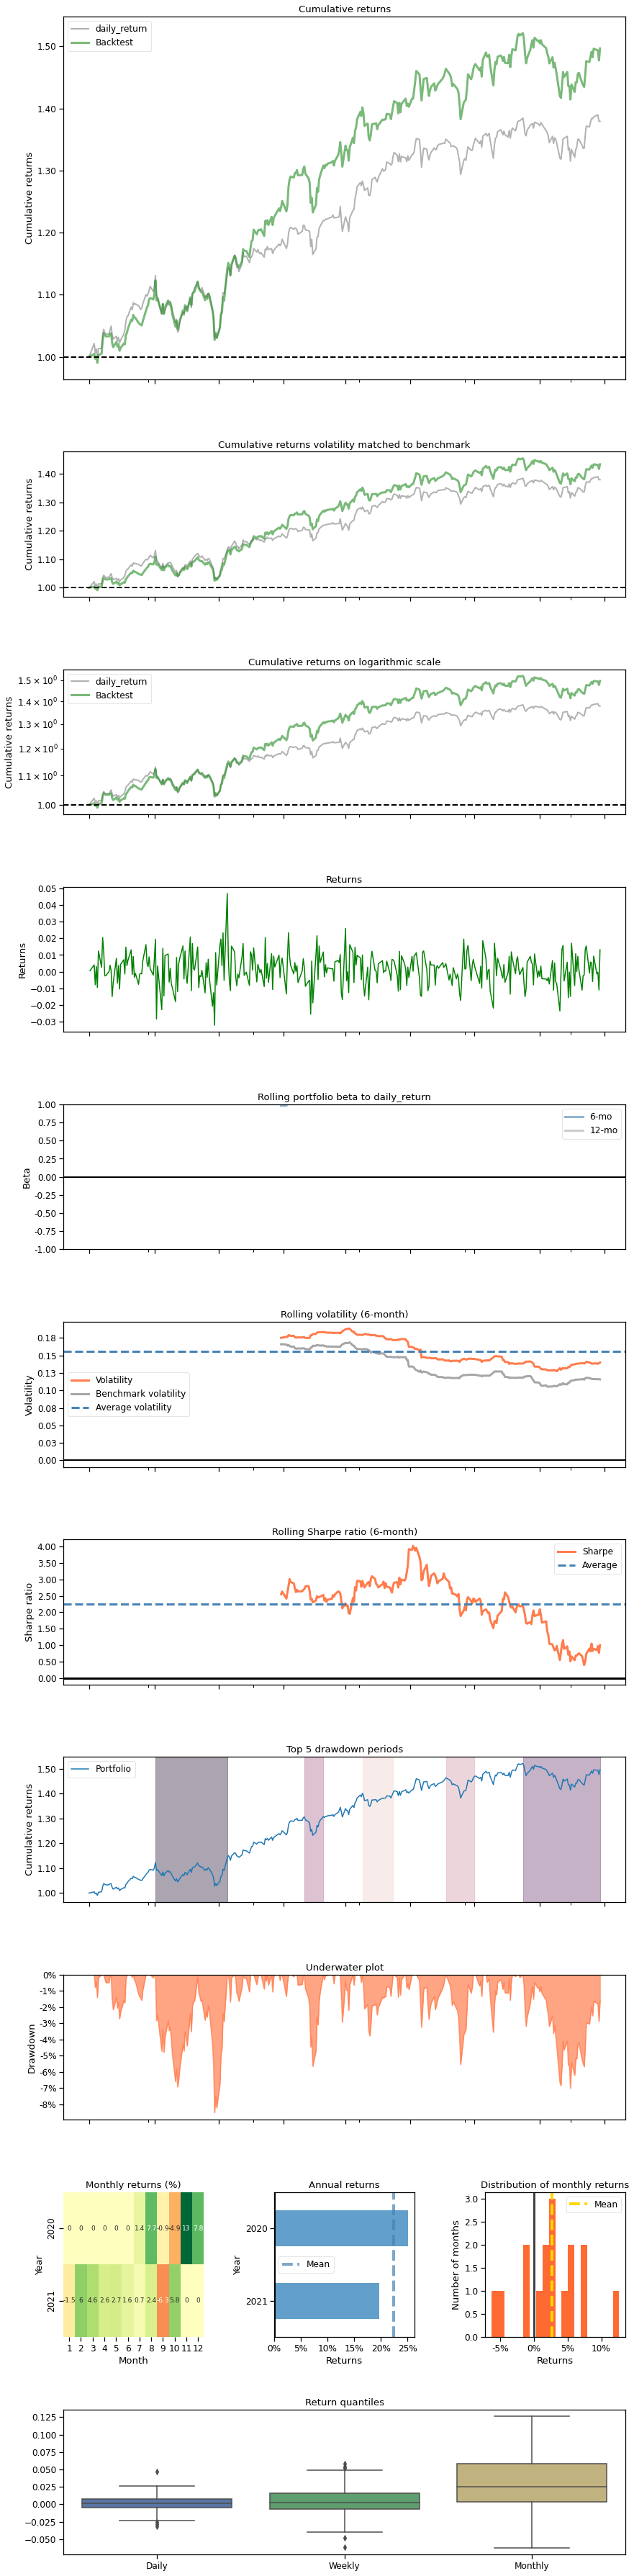

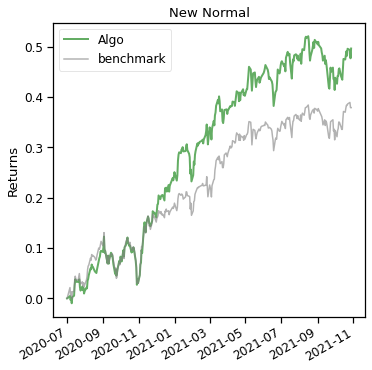

In [50]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])